<a id='Q0'></a>
<center> <h1>Telecom Churn Prediction (Classification) </h1> </center>
<p style="margin-bottom:1cm;"></p>
<center><h4>Propulsion Academy - Applied Machine Learning, 7 May 2021</h4></center>
<center><h5>Miniproject - Akos Redey</h5></center>
<p style="margin-bottom:1cm;"></p>

<div style="background:#EEEDF5;border-top:0.1cm solid #EF475B;border-bottom:0.1cm solid #EF475B;color:#303030">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm">
        <p><strong>Goal:</strong> Use Kaggle Dataset for predicting the Churn (refusal of contract renewal) of some Telecom Customers.</p>
        <p> <strong> Outline:</strong>
        <a id="P0" name="P0"></a>
        <ol>
            <li> <a href='#I'>Import Libraries </a> </li>
            <li> <a href='#C1'>Data load and basic checks</a></li>
            <li> <a href='#C2'>Data Imputations and Cleansing</a></li>
            <li> <a href='#C3'>Exploratory Data Analysis</a></li>
            <li> <a href='#C4'>Preprocessing</a></li>
            <li> <a href='#C5'>Building models for prediction</a></li>
            <li> <a href='#C6'>Hyperparameter tuning</a></li>
            <li> <a href='#C7'>Compare model performance</a></li>
            <li> <a href='#C8'>Select final model and save model artifacts</a></li>
            <li> <a href='#C9'>Model Interpretation</a></li>
            <li> <a href='#C10'>Predict and draw conclusions</a></li>
            <li> <a href='#AML'>Try AutoML Model Recommendation</a></li>
         </ol>
     </div>
    <a href='https://www.kaggle.com/radmirzosimov/telecom-users-dataset'>Link to the Dataset</a>
</div>

<a name='I'></a>
## <font color='darkblue'>__Import Libraries__</font>

In [1]:
# General libraries
import os
import pathlib
import pandas as pd
import numpy as np
from scipy import stats
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Sckit-Learn processing libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    roc_curve,
    plot_roc_curve,
    plot_precision_recall_curve,
    f1_score,
    roc_auc_score
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# Sckit-learn model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import shap
from pycaret.classification import *
from lime.lime_tabular import LimeTabularExplainer

In [4]:
workdir = pathlib.Path().absolute()
project_dir = workdir.parent
data_path = f"{project_dir}\\datasets\\"

In [5]:
def f1_scorer(clf, X, y):
    y_pred = clf.predict(X)
    return f1_score(y, y_pred, pos_label='Yes')


<a name='C1'></a>
## <font color='darkblue'>__Data Load & Basic Checks__</font>

In [6]:
df = pd.read_csv(data_path+'telecom_users.csv')

In [7]:
df.tail()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5981,3772,0684-AOSIH,Male,0,Yes,No,1,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95,Yes
5982,5191,5982-PSMKW,Female,0,Yes,Yes,23,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.3,No
5983,5226,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No
5984,5390,7450-NWRTR,Male,1,No,No,12,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes
5985,860,4795-UXVCJ,Male,0,No,No,26,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.80,457.3,No


In [8]:
df.shape

(5986, 22)

In [9]:
df.isna().sum()

Unnamed: 0          0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


In [11]:
df.loc[:, (df==0).any()]

,Unnamed: 0,SeniorCitizen,tenure
0,1869,0,72
1,4528,0,44
2,6344,1,38
3,6739,0,4
4,432,0,2
...,...,...,...
5981,3772,0,1
5982,5191,0,23
5983,5226,0,12
5984,5390,1,12


In [12]:
df[df['tenure']==0]

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
634,1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
2771,3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
3086,5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3255,3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
4326,936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
5375,753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5382,4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5695,488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
5951,1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


In [13]:
df[df['SeniorCitizen']==0]

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No
5,2215,4312-GVYNH,Female,0,Yes,No,70,No,No phone service,DSL,Yes,No,Yes,Yes,No,Yes,Two year,Yes,Bank transfer (automatic),49.85,3370.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,3092,6032-IGALN,Female,0,No,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,25.10,25.1,Yes
5981,3772,0684-AOSIH,Male,0,Yes,No,1,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95,Yes
5982,5191,5982-PSMKW,Female,0,Yes,Yes,23,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.3,No
5983,5226,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No


In [14]:
df[(df==' ')].any()

Unnamed: 0          False
customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges         True
Churn               False
dtype: bool

In [15]:
df[df['TotalCharges']==" "]

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
634,1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
2771,3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
3086,5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3255,3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
4326,936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
5375,753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5382,4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5695,488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
5951,1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


In [16]:
df['Contract'].value_counts()

Month-to-month    3269
Two year          1441
One year          1276
Name: Contract, dtype: int64

In [17]:
df.duplicated().sum()

0

In [18]:
df.nunique()

Unnamed: 0          5986
customerID          5986
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1526
TotalCharges        5611
Churn                  2
dtype: int64

In [19]:
df[df['customerID'].isna()]

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


<a name='C2'></a>
## <font color='darkblue'>__Data Imputations and Cleansing__</font>

<p>We have to make the following basic conversions:</p>
<li>drop the column "Unnamed: 0"</li>
<li>convert the column  "SeniorCitizen" back to dtype(object) and the values to Yes, No (from 1, 0)</li>
<li>impute the  empty records in column "TotalCharges" - they are customers, which are there with tenure 0 (less than a month) their charge can be equal to a monthly charge</li>
<li>convert the column "TotalCharge" to dtype(float64)</li>
<li>correct the zero values in column "tenure" to 1 (with the assumption that customers in the dataset have min one month tenure - it does not make a difference for churn prediction)</li>

We remove the "Unnamed: 0" column

In [20]:
final_columns = set(df.columns) - set(['Unnamed: 0'])
final_columns = list(final_columns)
final_columns

['MonthlyCharges',
 'PhoneService',
 'TechSupport',
 'PaymentMethod',
 'PaperlessBilling',
 'StreamingTV',
 'OnlineBackup',
 'OnlineSecurity',
 'InternetService',
 'gender',
 'Contract',
 'MultipleLines',
 'TotalCharges',
 'Churn',
 'DeviceProtection',
 'Dependents',
 'SeniorCitizen',
 'StreamingMovies',
 'Partner',
 'tenure',
 'customerID']

In [21]:
df_selected = df.copy()
df_selected = df_selected[final_columns]
df_selected.head()

,MonthlyCharges,PhoneService,TechSupport,PaymentMethod,PaperlessBilling,StreamingTV,OnlineBackup,OnlineSecurity,InternetService,gender,Contract,MultipleLines,TotalCharges,Churn,DeviceProtection,Dependents,SeniorCitizen,StreamingMovies,Partner,tenure,customerID
0,24.10,Yes,No internet service,Credit card (automatic),No,No internet service,No internet service,No internet service,No,Male,Two year,Yes,1734.65,No,No internet service,Yes,0,No internet service,Yes,72,7010-BRBUU
1,88.15,Yes,No,Credit card (automatic),Yes,Yes,Yes,No,Fiber optic,Female,Month-to-month,No,3973.2,No,Yes,No,0,No,No,44,9688-YGXVR
2,74.95,Yes,No,Bank transfer (automatic),Yes,No,No,No,Fiber optic,Female,Month-to-month,Yes,2869.85,Yes,No,No,1,No,Yes,38,9286-DOJGF
3,55.90,Yes,No,Electronic check,Yes,No,No,No,DSL,Male,Month-to-month,No,238.5,No,No,No,0,Yes,No,4,6994-KERXL
4,53.45,Yes,No,Electronic check,No,No,No,Yes,DSL,Male,Month-to-month,No,119.5,No,Yes,No,0,No,No,2,2181-UAESM


In [22]:
df_selected['SeniorCitizen'] = df_selected['SeniorCitizen'].replace({0: "No", 1: "Yes"})

In [23]:
df_selected['TotalCharges'] = df_selected['TotalCharges'].replace({" ": np.nan})

In [24]:
df_selected[df_selected['TotalCharges'].isna()]

,MonthlyCharges,PhoneService,TechSupport,PaymentMethod,PaperlessBilling,StreamingTV,OnlineBackup,OnlineSecurity,InternetService,gender,Contract,MultipleLines,TotalCharges,Churn,DeviceProtection,Dependents,SeniorCitizen,StreamingMovies,Partner,tenure,customerID
356,61.90,Yes,Yes,Bank transfer (automatic),Yes,No,Yes,Yes,DSL,Male,Two year,Yes,NaN,No,No,Yes,No,No,No,0,2775-SEFEE
634,56.05,No,Yes,Credit card (automatic),No,Yes,Yes,Yes,DSL,Female,Two year,No phone service,NaN,No,Yes,Yes,No,No,Yes,0,1371-DWPAZ
2771,25.35,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Male,Two year,Yes,NaN,No,No internet service,Yes,No,No internet service,Yes,0,3213-VVOLG
3086,19.70,Yes,No internet service,Mailed check,Yes,No internet service,No internet service,No internet service,No,Male,One year,No,NaN,No,No internet service,Yes,No,No internet service,Yes,0,2923-ARZLG
3255,19.85,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Male,Two year,No,NaN,No,No internet service,Yes,No,No internet service,Yes,0,7644-OMVMY
4326,80.85,Yes,No,Mailed check,No,Yes,Yes,Yes,DSL,Female,Two year,No,NaN,No,Yes,Yes,No,Yes,Yes,0,5709-LVOEQ
5375,20.25,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Male,Two year,No,NaN,No,No internet service,Yes,No,No internet service,No,0,3115-CZMZD
5382,20.00,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Female,Two year,No,NaN,No,No internet service,Yes,No,No internet service,Yes,0,2520-SGTTA
5695,52.55,No,Yes,Bank transfer (automatic),Yes,Yes,No,Yes,DSL,Female,Two year,No phone service,NaN,No,Yes,Yes,No,No,Yes,0,4472-LVYGI
5951,25.75,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Male,Two year,Yes,NaN,No,No internet service,Yes,No,No internet service,Yes,0,4367-NUYAO


In [25]:
df_selected['TotalCharges'] = np.where(df_selected['TotalCharges'].isnull(), df_selected['MonthlyCharges'], df_selected['TotalCharges'])

In [26]:
df_selected['TotalCharges'] = df_selected['TotalCharges'].astype(float)

In [27]:
df_selected[df_selected['tenure']==0]

,MonthlyCharges,PhoneService,TechSupport,PaymentMethod,PaperlessBilling,StreamingTV,OnlineBackup,OnlineSecurity,InternetService,gender,Contract,MultipleLines,TotalCharges,Churn,DeviceProtection,Dependents,SeniorCitizen,StreamingMovies,Partner,tenure,customerID
356,61.90,Yes,Yes,Bank transfer (automatic),Yes,No,Yes,Yes,DSL,Male,Two year,Yes,61.90,No,No,Yes,No,No,No,0,2775-SEFEE
634,56.05,No,Yes,Credit card (automatic),No,Yes,Yes,Yes,DSL,Female,Two year,No phone service,56.05,No,Yes,Yes,No,No,Yes,0,1371-DWPAZ
2771,25.35,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Male,Two year,Yes,25.35,No,No internet service,Yes,No,No internet service,Yes,0,3213-VVOLG
3086,19.70,Yes,No internet service,Mailed check,Yes,No internet service,No internet service,No internet service,No,Male,One year,No,19.70,No,No internet service,Yes,No,No internet service,Yes,0,2923-ARZLG
3255,19.85,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Male,Two year,No,19.85,No,No internet service,Yes,No,No internet service,Yes,0,7644-OMVMY
4326,80.85,Yes,No,Mailed check,No,Yes,Yes,Yes,DSL,Female,Two year,No,80.85,No,Yes,Yes,No,Yes,Yes,0,5709-LVOEQ
5375,20.25,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Male,Two year,No,20.25,No,No internet service,Yes,No,No internet service,No,0,3115-CZMZD
5382,20.00,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Female,Two year,No,20.00,No,No internet service,Yes,No,No internet service,Yes,0,2520-SGTTA
5695,52.55,No,Yes,Bank transfer (automatic),Yes,Yes,No,Yes,DSL,Female,Two year,No phone service,52.55,No,Yes,Yes,No,No,Yes,0,4472-LVYGI
5951,25.75,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Male,Two year,Yes,25.75,No,No internet service,Yes,No,No internet service,Yes,0,4367-NUYAO


In [28]:
df_selected['tenure'] = df_selected['tenure'].replace({0: 1})

In [29]:
df_selected[df_selected['tenure']==1]

,MonthlyCharges,PhoneService,TechSupport,PaymentMethod,PaperlessBilling,StreamingTV,OnlineBackup,OnlineSecurity,InternetService,gender,Contract,MultipleLines,TotalCharges,Churn,DeviceProtection,Dependents,SeniorCitizen,StreamingMovies,Partner,tenure,customerID
7,24.90,No,No,Mailed check,Yes,No,No,No,DSL,Female,Month-to-month,No phone service,24.90,No,No,No,No,No,No,1,4367-NHWMM
16,74.30,Yes,Yes,Mailed check,Yes,No,No,No,Fiber optic,Male,Month-to-month,No,74.30,No,No,No,No,No,No,1,2468-SJFLM
24,69.65,Yes,No,Electronic check,Yes,No,No,No,Fiber optic,Female,Month-to-month,No,69.65,Yes,No,No,Yes,No,No,1,4871-JTKJF
26,45.10,Yes,No,Mailed check,No,No,No,No,DSL,Female,Month-to-month,No,45.10,Yes,No,No,Yes,No,No,1,4193-ORFCL
27,25.75,Yes,No internet service,Mailed check,Yes,No internet service,No internet service,No internet service,No,Female,Month-to-month,Yes,25.75,No,No internet service,No,No,No internet service,No,1,2692-PFYTJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5951,25.75,Yes,No internet service,Mailed check,No,No internet service,No internet service,No internet service,No,Male,Two year,Yes,25.75,No,No internet service,Yes,No,No internet service,Yes,1,4367-NUYAO
5952,74.70,Yes,No,Electronic check,Yes,No,Yes,No,Fiber optic,Female,Month-to-month,No,74.70,Yes,No,Yes,No,No,Yes,1,9399-APLBT
5973,76.40,Yes,No,Mailed check,Yes,No,Yes,No,Fiber optic,Female,Month-to-month,No,76.40,Yes,No,No,Yes,No,Yes,1,3296-SILRA
5980,25.10,No,No,Mailed check,Yes,No,No,No,DSL,Female,Month-to-month,No phone service,25.10,Yes,No,No,No,No,No,1,6032-IGALN


In [30]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MonthlyCharges    5986 non-null   float64
 1   PhoneService      5986 non-null   object 
 2   TechSupport       5986 non-null   object 
 3   PaymentMethod     5986 non-null   object 
 4   PaperlessBilling  5986 non-null   object 
 5   StreamingTV       5986 non-null   object 
 6   OnlineBackup      5986 non-null   object 
 7   OnlineSecurity    5986 non-null   object 
 8   InternetService   5986 non-null   object 
 9   gender            5986 non-null   object 
 10  Contract          5986 non-null   object 
 11  MultipleLines     5986 non-null   object 
 12  TotalCharges      5986 non-null   float64
 13  Churn             5986 non-null   object 
 14  DeviceProtection  5986 non-null   object 
 15  Dependents        5986 non-null   object 
 16  SeniorCitizen     5986 non-null   object 


In [31]:
df_selected.tail()

,MonthlyCharges,PhoneService,TechSupport,PaymentMethod,PaperlessBilling,StreamingTV,OnlineBackup,OnlineSecurity,InternetService,gender,Contract,MultipleLines,TotalCharges,Churn,DeviceProtection,Dependents,SeniorCitizen,StreamingMovies,Partner,tenure,customerID
5981,95.00,Yes,No,Electronic check,Yes,Yes,No,Yes,Fiber optic,Male,Month-to-month,No,95.00,Yes,No,No,No,Yes,Yes,1,0684-AOSIH
5982,91.10,Yes,Yes,Credit card (automatic),Yes,Yes,Yes,Yes,DSL,Female,Two year,Yes,2198.30,No,Yes,Yes,No,Yes,Yes,23,5982-PSMKW
5983,21.15,Yes,No internet service,Electronic check,Yes,No internet service,No internet service,No internet service,No,Male,Month-to-month,No,306.05,No,No internet service,Yes,No,No internet service,Yes,12,8044-BGWPI
5984,99.45,Yes,No,Electronic check,Yes,Yes,No,No,Fiber optic,Male,Month-to-month,Yes,1200.15,Yes,Yes,No,Yes,Yes,No,12,7450-NWRTR
5985,19.80,Yes,No internet service,Credit card (automatic),No,No internet service,No internet service,No internet service,No,Male,One year,No,457.30,No,No internet service,No,No,No internet service,No,26,4795-UXVCJ


<a name='C3'></a>
## <font color='darkblue'>__Exploratory Data Analysis (EDA)__</font>

In [32]:
df_selected.isna().sum()

MonthlyCharges      0
PhoneService        0
TechSupport         0
PaymentMethod       0
PaperlessBilling    0
StreamingTV         0
OnlineBackup        0
OnlineSecurity      0
InternetService     0
gender              0
Contract            0
MultipleLines       0
TotalCharges        0
Churn               0
DeviceProtection    0
Dependents          0
SeniorCitizen       0
StreamingMovies     0
Partner             0
tenure              0
customerID          0
dtype: int64

### Visualizing relationship between churn and categorical variables

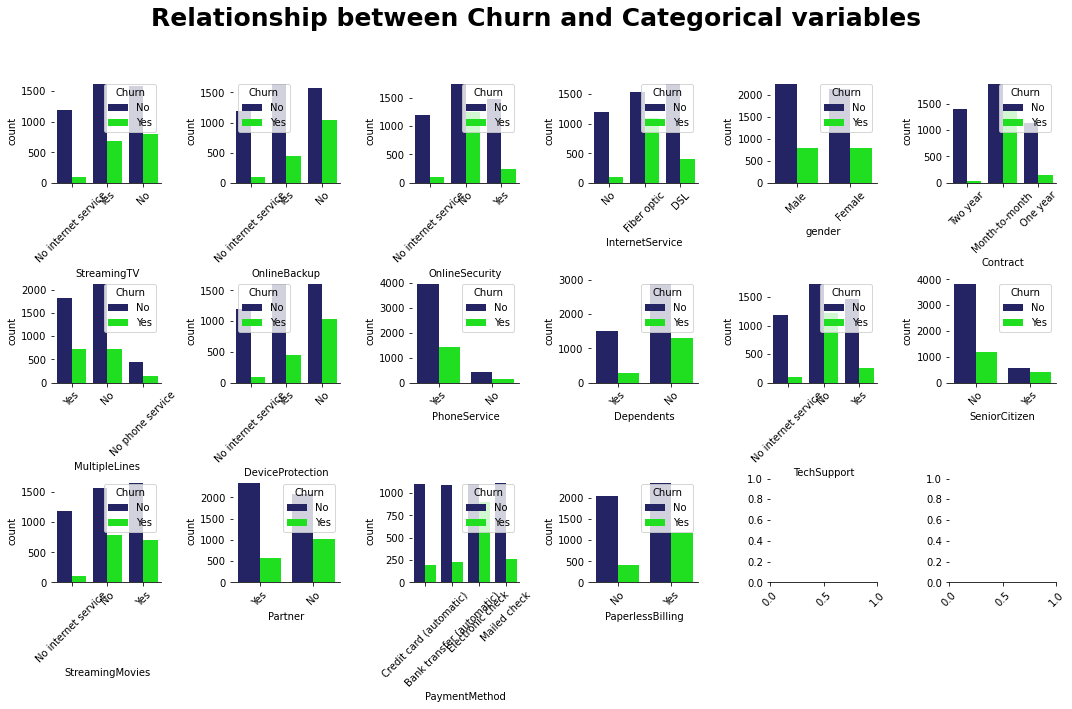

In [33]:
cat_features = set(df_selected.columns) - set(['tenure', 'Churn', 'MonthlyCharges', 'TotalCharges', 'customerID']) 

fig, axs = plt.subplots(ncols=6, nrows=3, figsize=(15,10))
for feat_num, feat_name in enumerate(cat_features):
    sns.countplot(data=df_selected, x=feat_name, hue='Churn', ax=axs[int(feat_num/6), feat_num%6], palette=['midnightblue', 'lime'])
    sns.despine(left=True)
for ax, dat in zip(axs.ravel(), df_selected):
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.suptitle("Relationship between Churn and Categorical variables", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

### Visualizing numerical variables

In [34]:
df_selected.describe()

,MonthlyCharges,TotalCharges,tenure
count,5986.000000,5986.000000,5986.000000
mean,64.802213,2294.285416,32.470431
std,30.114702,2274.100395,24.514212
min,18.250000,18.800000,1.000000
25%,35.650000,401.587500,9.000000
50%,70.400000,1408.575000,29.000000
75%,89.900000,3841.500000,56.000000
max,118.750000,8684.800000,72.000000


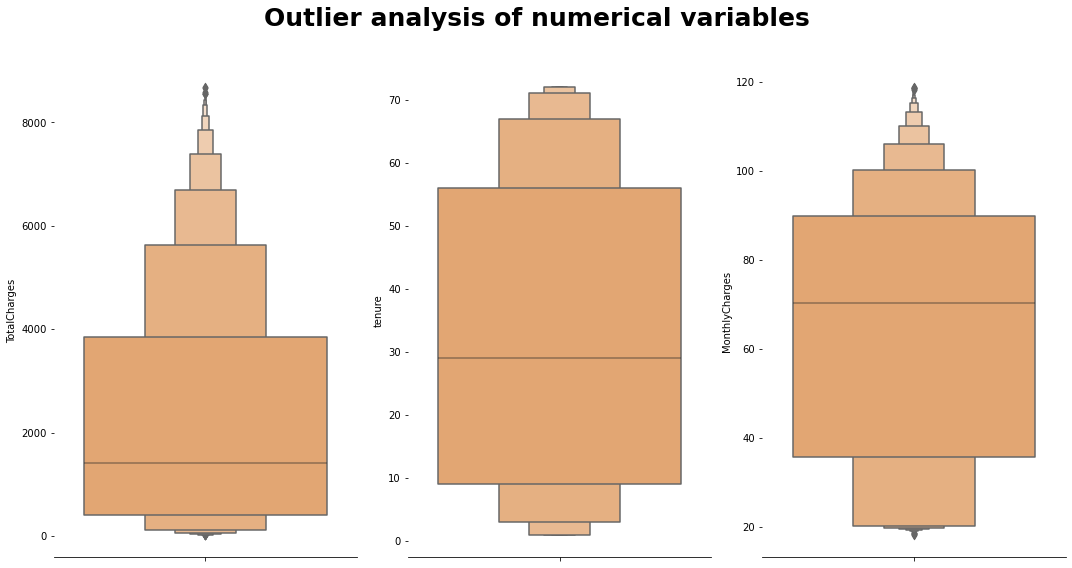

In [35]:
num_features = set(['tenure', 'MonthlyCharges', 'TotalCharges']) 

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15,8))
for feat_num, feat_name in enumerate(num_features):
    sns.boxenplot(y=df_selected[feat_name], ax=axs[feat_num%3], palette=['sandybrown'])
    sns.despine(left=True)
plt.tight_layout()
plt.suptitle("Outlier analysis of numerical variables", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

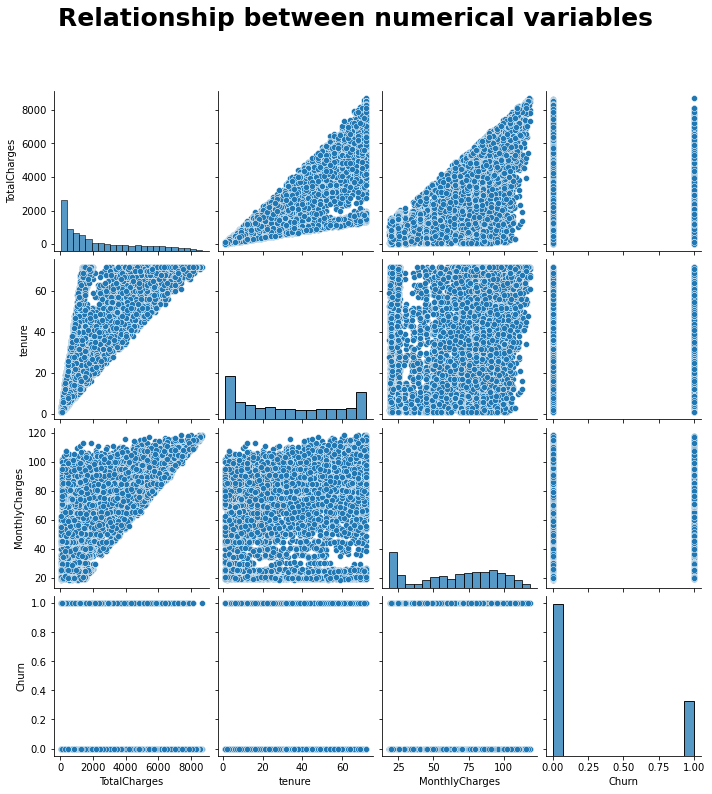

In [36]:
num_features_churn = num_features.copy()
num_features_churn.add('Churn')
df_pair = df_selected[num_features_churn].replace({'Yes': 1, 'No': 0})
sns.pairplot(df_pair)
plt.suptitle("Relationship between numerical variables", fontsize = 25, fontweight = 'bold', y=1.1)
plt.show()

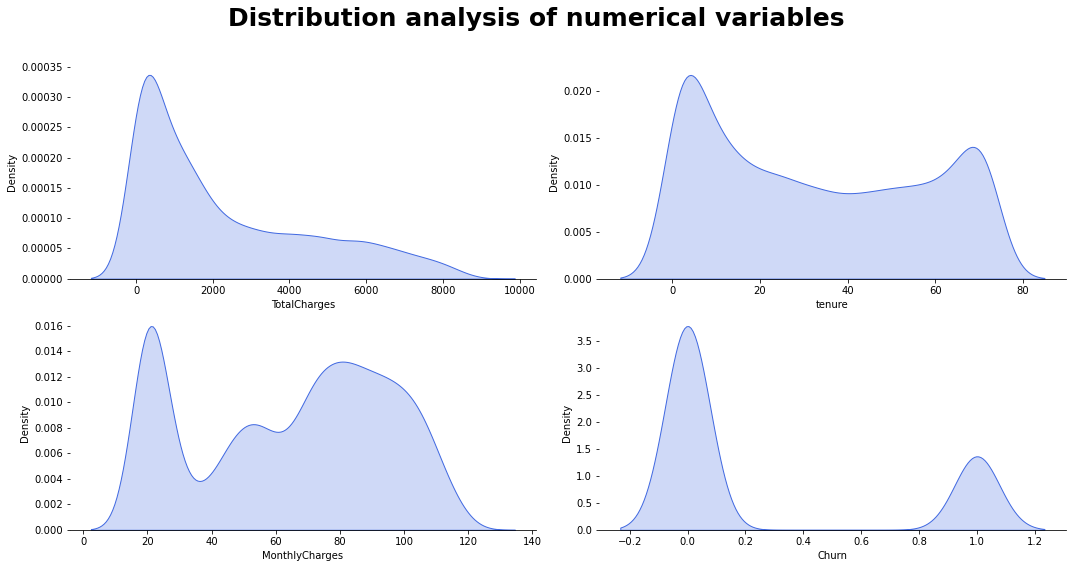

In [37]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,8))
for feat_num, feat_name in enumerate(num_features_churn):
    sns.kdeplot(df_pair[feat_name], ax=axs[int(feat_num/2), feat_num%2], fill=True, color='royalblue')
    sns.despine(left=True)
plt.tight_layout()
plt.suptitle("Distribution analysis of numerical variables", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

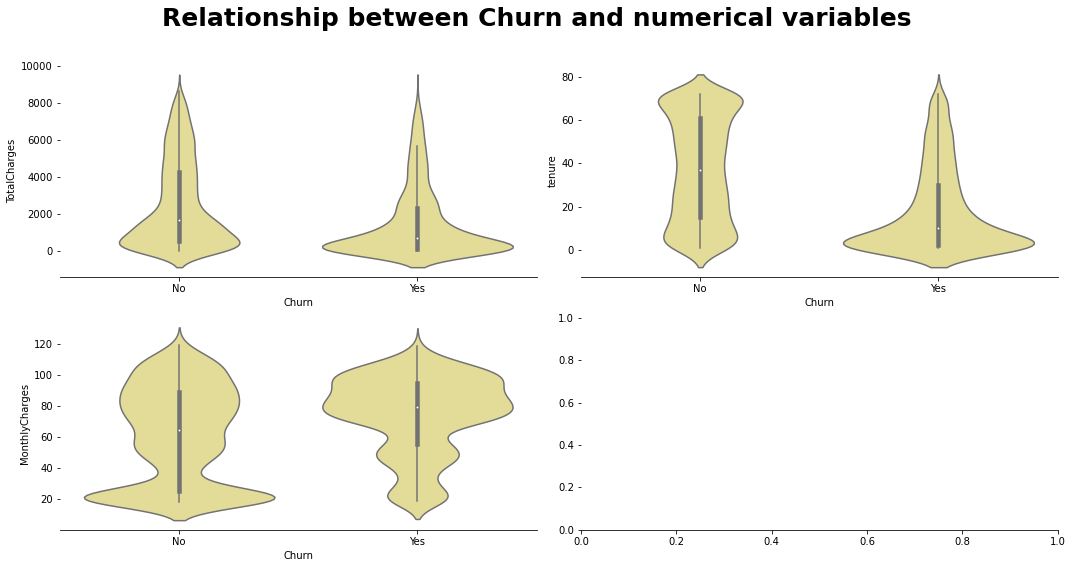

In [38]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,8))
for feat_num, feat_name in enumerate(num_features):
    sns.violinplot(x='Churn', y=feat_name, data=df_selected, ax=axs[int(feat_num/2), feat_num%2], palette=['khaki'])
    sns.despine(left=True)
plt.tight_layout()
plt.suptitle("Relationship between Churn and numerical variables", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

<a name='C4'></a>
## <font color='darkblue'>__Preprocessing__</font>

### Split Dataset into train and test

In [39]:
X = df_selected.drop(columns=['Churn', 'customerID'])
y = df_selected['Churn']

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MonthlyCharges    5986 non-null   float64
 1   PhoneService      5986 non-null   object 
 2   TechSupport       5986 non-null   object 
 3   PaymentMethod     5986 non-null   object 
 4   PaperlessBilling  5986 non-null   object 
 5   StreamingTV       5986 non-null   object 
 6   OnlineBackup      5986 non-null   object 
 7   OnlineSecurity    5986 non-null   object 
 8   InternetService   5986 non-null   object 
 9   gender            5986 non-null   object 
 10  Contract          5986 non-null   object 
 11  MultipleLines     5986 non-null   object 
 12  TotalCharges      5986 non-null   float64
 13  DeviceProtection  5986 non-null   object 
 14  Dependents        5986 non-null   object 
 15  SeniorCitizen     5986 non-null   object 
 16  StreamingMovies   5986 non-null   object 


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [42]:
X_train.shape, X_test.shape

((4190, 19), (1796, 19))

In [43]:
y_train.value_counts()

No     3079
Yes    1111
Name: Churn, dtype: int64

In [44]:
y_test.value_counts()

No     1320
Yes     476
Name: Churn, dtype: int64

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4190 entries, 3499 to 5829
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MonthlyCharges    4190 non-null   float64
 1   PhoneService      4190 non-null   object 
 2   TechSupport       4190 non-null   object 
 3   PaymentMethod     4190 non-null   object 
 4   PaperlessBilling  4190 non-null   object 
 5   StreamingTV       4190 non-null   object 
 6   OnlineBackup      4190 non-null   object 
 7   OnlineSecurity    4190 non-null   object 
 8   InternetService   4190 non-null   object 
 9   gender            4190 non-null   object 
 10  Contract          4190 non-null   object 
 11  MultipleLines     4190 non-null   object 
 12  TotalCharges      4190 non-null   float64
 13  DeviceProtection  4190 non-null   object 
 14  Dependents        4190 non-null   object 
 15  SeniorCitizen     4190 non-null   object 
 16  StreamingMovies   4190 non-null   objec

In [46]:
X_train_cat = X_train.select_dtypes(include='object')
X_train_num = X_train.select_dtypes(exclude='object')

In [47]:
X_train_cat.head()

,PhoneService,TechSupport,PaymentMethod,PaperlessBilling,StreamingTV,OnlineBackup,OnlineSecurity,InternetService,gender,Contract,MultipleLines,DeviceProtection,Dependents,SeniorCitizen,StreamingMovies,Partner
3499,Yes,No internet service,Bank transfer (automatic),No,No internet service,No internet service,No internet service,No,Male,One year,No,No internet service,No,No,No internet service,No
579,Yes,Yes,Credit card (automatic),No,Yes,Yes,Yes,Fiber optic,Male,One year,Yes,Yes,No,No,No,No
3722,Yes,Yes,Credit card (automatic),Yes,Yes,Yes,No,Fiber optic,Male,Two year,Yes,Yes,No,No,Yes,Yes
247,No,Yes,Credit card (automatic),No,No,No,Yes,DSL,Female,One year,No phone service,No,Yes,No,No,Yes
5154,Yes,No,Electronic check,Yes,Yes,No,No,Fiber optic,Male,Month-to-month,Yes,No,No,No,No,Yes


In [48]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4190 entries, 3499 to 5829
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PhoneService      4190 non-null   object
 1   TechSupport       4190 non-null   object
 2   PaymentMethod     4190 non-null   object
 3   PaperlessBilling  4190 non-null   object
 4   StreamingTV       4190 non-null   object
 5   OnlineBackup      4190 non-null   object
 6   OnlineSecurity    4190 non-null   object
 7   InternetService   4190 non-null   object
 8   gender            4190 non-null   object
 9   Contract          4190 non-null   object
 10  MultipleLines     4190 non-null   object
 11  DeviceProtection  4190 non-null   object
 12  Dependents        4190 non-null   object
 13  SeniorCitizen     4190 non-null   object
 14  StreamingMovies   4190 non-null   object
 15  Partner           4190 non-null   object
dtypes: object(16)
memory usage: 556.5+ KB


In [49]:
X_train_cat.loc[:, (X_train_cat==" ").any()]

""
3499
579
3722
247
5154
...
3339
4496
3202
782


In [50]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4190 entries, 3499 to 5829
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MonthlyCharges  4190 non-null   float64
 1   TotalCharges    4190 non-null   float64
 2   tenure          4190 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 130.9 KB


In [51]:
X_train_num.loc[:, (X_train_num==0).any()]

""
3499
579
3722
247
5154
...
3339
4496
3202
782


### Impute missing data in Categorical Features

In [52]:
cat_cols = X_train_cat.columns
cat_imputer = SimpleImputer(strategy='constant', fill_value='Not Available', verbose=1)
X_train_cat = pd.DataFrame(cat_imputer.fit_transform(X_train_cat), columns=cat_cols)

### One-Hot Encoding Categorical Features

In [53]:
cat_dummy_encoder = OneHotEncoder(handle_unknown='ignore')
X_train_cat_ohe = cat_dummy_encoder.fit_transform(X_train_cat).toarray()
X_train_cat_ohe, cat_dummy_encoder.get_feature_names(cat_cols)

(array([[0., 1., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 1., 0., 1.],
        ...,
        [0., 1., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 1., 0., 1.],
        [0., 1., 0., ..., 0., 1., 0.]]),
 array(['PhoneService_No', 'PhoneService_Yes', 'TechSupport_No',
        'TechSupport_No internet service', 'TechSupport_Yes',
        'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        'PaperlessBilling_No', 'PaperlessBilling_Yes', 'StreamingTV_No',
        'StreamingTV_No internet service', 'StreamingTV_Yes',
        'OnlineBackup_No', 'OnlineBackup_No internet service',
        'OnlineBackup_Yes', 'OnlineSecurity_No',
        'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
        'InternetService_DSL', 'InternetService_Fiber optic',
        'InternetService_No', 'gender_Female', 'gender_Male',
        'Cont

In [54]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190 entries, 0 to 4189
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PhoneService      4190 non-null   object
 1   TechSupport       4190 non-null   object
 2   PaymentMethod     4190 non-null   object
 3   PaperlessBilling  4190 non-null   object
 4   StreamingTV       4190 non-null   object
 5   OnlineBackup      4190 non-null   object
 6   OnlineSecurity    4190 non-null   object
 7   InternetService   4190 non-null   object
 8   gender            4190 non-null   object
 9   Contract          4190 non-null   object
 10  MultipleLines     4190 non-null   object
 11  DeviceProtection  4190 non-null   object
 12  Dependents        4190 non-null   object
 13  SeniorCitizen     4190 non-null   object
 14  StreamingMovies   4190 non-null   object
 15  Partner           4190 non-null   object
dtypes: object(16)
memory usage: 523.9+ KB


In [55]:
cat_ohe_cols = cat_dummy_encoder.get_feature_names(cat_cols)
X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe,
                              columns=cat_ohe_cols)

In [56]:
X_train_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190 entries, 0 to 4189
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   PhoneService_No                          4190 non-null   float64
 1   PhoneService_Yes                         4190 non-null   float64
 2   TechSupport_No                           4190 non-null   float64
 3   TechSupport_No internet service          4190 non-null   float64
 4   TechSupport_Yes                          4190 non-null   float64
 5   PaymentMethod_Bank transfer (automatic)  4190 non-null   float64
 6   PaymentMethod_Credit card (automatic)    4190 non-null   float64
 7   PaymentMethod_Electronic check           4190 non-null   float64
 8   PaymentMethod_Mailed check               4190 non-null   float64
 9   PaperlessBilling_No                      4190 non-null   float64
 10  PaperlessBilling_Yes                     4190 no

In [57]:
X_train_cat_ohe.tail()

,PhoneService_No,PhoneService_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling_No,PaperlessBilling_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,Dependents_No,Dependents_Yes,SeniorCitizen_No,SeniorCitizen_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Partner_No,Partner_Yes
4185,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4186,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4187,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4188,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4189,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### Remove duplicate columns

<p>For some categories, there is an answer: "No Internet service" or "No phone service", but we have categories, which filter for the missing internet or phone service.</p>
<p>Therefore after One-Hot encoding these answers will become separate columns, but these columns have no added value for the model, so we can drop them accordingly.</p>

In [58]:
X_train_cat_ohe[['InternetService_No', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'OnlineSecurity_No internet service', 'StreamingMovies_No internet service',
                'StreamingTV_No internet service', 'OnlineBackup_No internet service']]

,InternetService_No,DeviceProtection_No internet service,TechSupport_No internet service,OnlineSecurity_No internet service,StreamingMovies_No internet service,StreamingTV_No internet service,OnlineBackup_No internet service
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
4185,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4186,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4187,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4188,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
X_train_cat_ohe[['InternetService_No', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'OnlineSecurity_No internet service', 'StreamingMovies_No internet service',
                'StreamingTV_No internet service', 'OnlineBackup_No internet service']].sum()

InternetService_No                      919.0
DeviceProtection_No internet service    919.0
TechSupport_No internet service         919.0
OnlineSecurity_No internet service      919.0
StreamingMovies_No internet service     919.0
StreamingTV_No internet service         919.0
OnlineBackup_No internet service        919.0
dtype: float64

In [60]:
X_train_cat_ohe[['PhoneService_No', 'MultipleLines_No phone service']]

,PhoneService_No,MultipleLines_No phone service
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,1.0
4,0.0,0.0
...,...,...
4185,0.0,0.0
4186,0.0,0.0
4187,0.0,0.0
4188,0.0,0.0


In [61]:
X_train_cat_ohe[['PhoneService_No', 'MultipleLines_No phone service']].sum()

PhoneService_No                   419.0
MultipleLines_No phone service    419.0
dtype: float64

In [62]:
X_train_cat_ohe = X_train_cat_ohe.drop(columns=['DeviceProtection_No internet service', 'TechSupport_No internet service', 'OnlineSecurity_No internet service', 'StreamingMovies_No internet service',
                'StreamingTV_No internet service', 'OnlineBackup_No internet service', 'MultipleLines_No phone service'])

In [63]:
X_train_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190 entries, 0 to 4189
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   PhoneService_No                          4190 non-null   float64
 1   PhoneService_Yes                         4190 non-null   float64
 2   TechSupport_No                           4190 non-null   float64
 3   TechSupport_Yes                          4190 non-null   float64
 4   PaymentMethod_Bank transfer (automatic)  4190 non-null   float64
 5   PaymentMethod_Credit card (automatic)    4190 non-null   float64
 6   PaymentMethod_Electronic check           4190 non-null   float64
 7   PaymentMethod_Mailed check               4190 non-null   float64
 8   PaperlessBilling_No                      4190 non-null   float64
 9   PaperlessBilling_Yes                     4190 non-null   float64
 10  StreamingTV_No                           4190 no

In [64]:
X_train_cat_ohe.isna().sum()

PhoneService_No                            0
PhoneService_Yes                           0
TechSupport_No                             0
TechSupport_Yes                            0
PaymentMethod_Bank transfer (automatic)    0
PaymentMethod_Credit card (automatic)      0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
PaperlessBilling_No                        0
PaperlessBilling_Yes                       0
StreamingTV_No                             0
StreamingTV_Yes                            0
OnlineBackup_No                            0
OnlineBackup_Yes                           0
OnlineSecurity_No                          0
OnlineSecurity_Yes                         0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
gender_Female                              0
gender_Male                                0
Contract_Month-to-month                    0
Contract_O

### Impute missing data in Numeric Features

In [65]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4190 entries, 3499 to 5829
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MonthlyCharges  4190 non-null   float64
 1   TotalCharges    4190 non-null   float64
 2   tenure          4190 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 130.9 KB


In [66]:
num_cols = X_train_num.columns
knn_imp = KNNImputer(n_neighbors=5)
X_train_num = pd.DataFrame(knn_imp.fit_transform(X_train_num), columns=num_cols)

### Scale numeric variables

In [67]:
scaler = StandardScaler()
X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_cols)

In [68]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190 entries, 0 to 4189
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MonthlyCharges  4190 non-null   float64
 1   TotalCharges    4190 non-null   float64
 2   tenure          4190 non-null   float64
dtypes: float64(3)
memory usage: 98.3 KB


In [69]:
X_train_num.isna().sum()

MonthlyCharges    0
TotalCharges      0
tenure            0
dtype: int64

### Combine Numeric and encoded Categorical Features

In [70]:
X_train = pd.concat([X_train_num, X_train_cat_ohe], axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4190 entries, 0 to 4189
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   MonthlyCharges                           4190 non-null   float64
 1   TotalCharges                             4190 non-null   float64
 2   tenure                                   4190 non-null   float64
 3   PhoneService_No                          4190 non-null   float64
 4   PhoneService_Yes                         4190 non-null   float64
 5   TechSupport_No                           4190 non-null   float64
 6   TechSupport_Yes                          4190 non-null   float64
 7   PaymentMethod_Bank transfer (automatic)  4190 non-null   float64
 8   PaymentMethod_Credit card (automatic)    4190 non-null   float64
 9   PaymentMethod_Electronic check           4190 non-null   float64
 10  PaymentMethod_Mailed check               4190 no

In [71]:
X_train.isna().sum()

MonthlyCharges                             0
TotalCharges                               0
tenure                                     0
PhoneService_No                            0
PhoneService_Yes                           0
TechSupport_No                             0
TechSupport_Yes                            0
PaymentMethod_Bank transfer (automatic)    0
PaymentMethod_Credit card (automatic)      0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
PaperlessBilling_No                        0
PaperlessBilling_Yes                       0
StreamingTV_No                             0
StreamingTV_Yes                            0
OnlineBackup_No                            0
OnlineBackup_Yes                           0
OnlineSecurity_No                          0
OnlineSecurity_Yes                         0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
gender_Fem

In [72]:
X_train.head()

,MonthlyCharges,TotalCharges,tenure,PhoneService_No,PhoneService_Yes,TechSupport_No,TechSupport_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling_No,PaperlessBilling_Yes,StreamingTV_No,StreamingTV_Yes,OnlineBackup_No,OnlineBackup_Yes,OnlineSecurity_No,OnlineSecurity_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,MultipleLines_No,MultipleLines_Yes,DeviceProtection_No,DeviceProtection_Yes,Dependents_No,Dependents_Yes,SeniorCitizen_No,SeniorCitizen_Yes,StreamingMovies_No,StreamingMovies_Yes,Partner_No,Partner_Yes
0,-1.472572,-0.757356,-0.216190,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.312451,1.897750,1.258381,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.447742,2.382286,1.586063,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,-1.041950,-0.809263,-0.830595,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.705289,-0.460957,-0.748674,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [73]:
final_dataset_columns = X_train.columns.values

In [74]:
final_dataset_columns

array(['MonthlyCharges', 'TotalCharges', 'tenure', 'PhoneService_No',
       'PhoneService_Yes', 'TechSupport_No', 'TechSupport_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'PaperlessBilling_No', 'PaperlessBilling_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'OnlineBackup_No', 'OnlineBackup_Yes',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'gender_Female', 'gender_Male', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'MultipleLines_No',
       'MultipleLines_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'Dependents_No', 'Dependents_Yes', 'SeniorCitizen_No',
       'SeniorCitizen_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'Partner_No', 'Partner_Yes'], dtype=object)

### Apply imputation and One-Hot encoding on Test data

In [75]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1796 entries, 3564 to 4851
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MonthlyCharges    1796 non-null   float64
 1   PhoneService      1796 non-null   object 
 2   TechSupport       1796 non-null   object 
 3   PaymentMethod     1796 non-null   object 
 4   PaperlessBilling  1796 non-null   object 
 5   StreamingTV       1796 non-null   object 
 6   OnlineBackup      1796 non-null   object 
 7   OnlineSecurity    1796 non-null   object 
 8   InternetService   1796 non-null   object 
 9   gender            1796 non-null   object 
 10  Contract          1796 non-null   object 
 11  MultipleLines     1796 non-null   object 
 12  TotalCharges      1796 non-null   float64
 13  DeviceProtection  1796 non-null   object 
 14  Dependents        1796 non-null   object 
 15  SeniorCitizen     1796 non-null   object 
 16  StreamingMovies   1796 non-null   objec

In [76]:
print(f"{cat_cols}\n"\
      f"{cat_ohe_cols}\n"\
      f"{num_cols}")

Index(['PhoneService', 'TechSupport', 'PaymentMethod', 'PaperlessBilling',
       'StreamingTV', 'OnlineBackup', 'OnlineSecurity', 'InternetService',
       'gender', 'Contract', 'MultipleLines', 'DeviceProtection', 'Dependents',
       'SeniorCitizen', 'StreamingMovies', 'Partner'],
      dtype='object')
['PhoneService_No' 'PhoneService_Yes' 'TechSupport_No'
 'TechSupport_No internet service' 'TechSupport_Yes'
 'PaymentMethod_Bank transfer (automatic)'
 'PaymentMethod_Credit card (automatic)' 'PaymentMethod_Electronic check'
 'PaymentMethod_Mailed check' 'PaperlessBilling_No' 'PaperlessBilling_Yes'
 'StreamingTV_No' 'StreamingTV_No internet service' 'StreamingTV_Yes'
 'OnlineBackup_No' 'OnlineBackup_No internet service' 'OnlineBackup_Yes'
 'OnlineSecurity_No' 'OnlineSecurity_No internet service'
 'OnlineSecurity_Yes' 'InternetService_DSL' 'InternetService_Fiber optic'
 'InternetService_No' 'gender_Female' 'gender_Male'
 'Contract_Month-to-month' 'Contract_One year' 'Contract_Two year'

In [77]:
X_test_cat = X_test[cat_cols]
X_test_num = X_test[num_cols]

In [78]:
X_test_cat = pd.DataFrame(cat_imputer.transform(X_test_cat), columns=cat_cols)
X_test_cat_ohe = cat_dummy_encoder.transform(X_test_cat).toarray()
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe, 
                               columns=cat_ohe_cols)

X_test_num = pd.DataFrame(knn_imp.transform(X_test_num), columns=num_cols)
X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=num_cols)

X_test = pd.concat([X_test_num, X_test_cat_ohe], axis=1)
X_test = X_test[final_dataset_columns]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   MonthlyCharges                           1796 non-null   float64
 1   TotalCharges                             1796 non-null   float64
 2   tenure                                   1796 non-null   float64
 3   PhoneService_No                          1796 non-null   float64
 4   PhoneService_Yes                         1796 non-null   float64
 5   TechSupport_No                           1796 non-null   float64
 6   TechSupport_Yes                          1796 non-null   float64
 7   PaymentMethod_Bank transfer (automatic)  1796 non-null   float64
 8   PaymentMethod_Credit card (automatic)    1796 non-null   float64
 9   PaymentMethod_Electronic check           1796 non-null   float64
 10  PaymentMethod_Mailed check               1796 no

In [79]:
X_test.isna().sum()

MonthlyCharges                             0
TotalCharges                               0
tenure                                     0
PhoneService_No                            0
PhoneService_Yes                           0
TechSupport_No                             0
TechSupport_Yes                            0
PaymentMethod_Bank transfer (automatic)    0
PaymentMethod_Credit card (automatic)      0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
PaperlessBilling_No                        0
PaperlessBilling_Yes                       0
StreamingTV_No                             0
StreamingTV_Yes                            0
OnlineBackup_No                            0
OnlineBackup_Yes                           0
OnlineSecurity_No                          0
OnlineSecurity_Yes                         0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
gender_Fem

In [80]:
X_test.head()

,MonthlyCharges,TotalCharges,tenure,PhoneService_No,PhoneService_Yes,TechSupport_No,TechSupport_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling_No,PaperlessBilling_Yes,StreamingTV_No,StreamingTV_Yes,OnlineBackup_No,OnlineBackup_Yes,OnlineSecurity_No,OnlineSecurity_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,MultipleLines_No,MultipleLines_Yes,DeviceProtection_No,DeviceProtection_Yes,Dependents_No,Dependents_Yes,SeniorCitizen_No,SeniorCitizen_Yes,StreamingMovies_No,StreamingMovies_Yes,Partner_No,Partner_Yes
0,-0.489235,-0.983174,-1.281158,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.309314,1.294997,1.545103,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.317400,2.029444,1.299341,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,-1.464323,-0.708643,0.070532,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.195308,-0.179071,-0.543873,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


### Encode target variable

In [81]:
y_train_orig = y_train.copy()
y_test_orig = y_test.copy()

label_encoder = LabelEncoder()

label_encoder = label_encoder.fit(y_train)
label_encoder_y = label_encoder.transform(y_train)
y_train_encoded = pd.DataFrame(label_encoder_y, columns=['Churn'])
y_train_encoded = y_train_encoded['Churn']

label_encoder_yt = label_encoder.transform(y_test)
y_test_encoded = pd.DataFrame(label_encoder_yt, columns=['Churn'])
y_test_encoded = y_test_encoded['Churn']


In [82]:
y_train_encoded

0       0
1       0
2       1
3       0
4       1
       ..
4185    1
4186    0
4187    1
4188    0
4189    0
Name: Churn, Length: 4190, dtype: int32

In [83]:
y_test_encoded

0       1
1       0
2       0
3       0
4       1
       ..
1791    1
1792    1
1793    0
1794    1
1795    0
Name: Churn, Length: 1796, dtype: int32

<a name='C5'></a>
## <font color='darkblue'>__Initial model building__</font>

#### Spot check Algorithms

In [84]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('NBC', GaussianNB()))
models.append(('LDA', LinearDiscriminantAnalysis())) 
models.append(('KNN', KNeighborsClassifier()))
models.append(('DSC', DecisionTreeClassifier(random_state=1)))
models.append(('ADA', AdaBoostClassifier(random_state=1)))
models.append(('RFC', RandomForestClassifier(random_state=1)))
models.append(('GRB', GradientBoostingClassifier(random_state=1)))
models.append(('SVM', SVC()))
models.append(('XGB', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')))

# evaluate each model in turn
results = []
names = []
scores = []
for name, model in models:
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=1)
    cv_results = cross_val_score(model, X_train, y_train_encoded, cv=kfold, scoring='accuracy') 
    results.append(cv_results)
    names.append(name)
    scores.append(cv_results.mean())
    msg = "%s: %.2f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.80 (0.015)
NBC: 0.74 (0.019)
LDA: 0.80 (0.018)
KNN: 0.77 (0.017)
DSC: 0.74 (0.019)
ADA: 0.80 (0.012)
RFC: 0.79 (0.016)
GRB: 0.80 (0.012)
SVM: 0.80 (0.016)
XGB: 0.78 (0.013)


In [85]:
df_scores = pd.DataFrame(scores, names, columns=['score'])

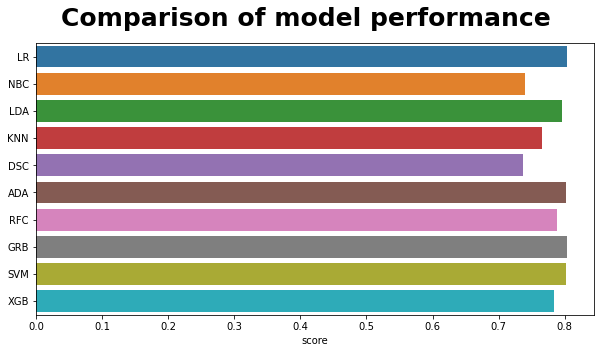

In [86]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='score', y=df_scores.index, data=df_scores)
plt.suptitle("Comparison of model performance", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

### Hypothesis Testing

<p>We assume that the models LR, LDA, ADA and GRB perform similarly, but we want to test the null hypothesis, that all 4 models perform equally well.</p>

In [87]:
# evaluate model 1
model1 = models[0][1]
model1_name = models[0][0]
cv1 = kfold
scores1 = cross_val_score(model1, X_train, y_train, scoring = 'accuracy', cv = cv1, n_jobs = -1)
print(model1_name+' Mean Accuracy: %.1f%% +/-(%.3f)' % ((scores1*100).mean(), (scores1).std()))

# evaluate model 2
model2 = models[2][1]
model2_name = models[2][0]
cv2 = kfold
scores2 = cross_val_score(model2, X_train, y_train, scoring = 'accuracy', cv = cv2, n_jobs = -1)
print(model2_name+' Mean Accuracy: %.1f%% +/-(%.3f)' % ((scores2*100).mean(), (scores2).std()))

# evaluate model 3
model3 = models[5][1]
model3_name = models[5][0]
cv3 = kfold
scores3 = cross_val_score(model3, X_train, y_train, scoring = 'accuracy', cv = cv3, n_jobs = -1)
print(model3_name+' Mean Accuracy: %.1f%% +/-(%.3f)' % ((scores3*100).mean(), (scores3).std()))

# evaluate model 4
model4 = models[7][1]
model4_name = models[7][0]
cv4 = kfold
scores4 = cross_val_score(model4, X_train, y_train, scoring = 'accuracy', cv = cv4, n_jobs = -1)
print(model4_name+' Mean Accuracy: %.1f%% +/-(%.3f)' % ((scores4*100).mean(), (scores4).std()))

# evaluate model 5
model5 = models[8][1]
model5_name = models[8][0]
cv5 = kfold
scores5 = cross_val_score(model5, X_train, y_train, scoring = 'accuracy', cv = cv5, n_jobs = -1)
print(model5_name+' Mean Accuracy: %.1f%% +/-(%.3f)' % ((scores5*100).mean(), (scores5).std()))

LR Mean Accuracy: 80.4% +/-(0.015)
LDA Mean Accuracy: 79.6% +/-(0.018)
ADA Mean Accuracy: 80.2% +/-(0.012)
GRB Mean Accuracy: 80.3% +/-(0.012)
SVM Mean Accuracy: 80.2% +/-(0.016)


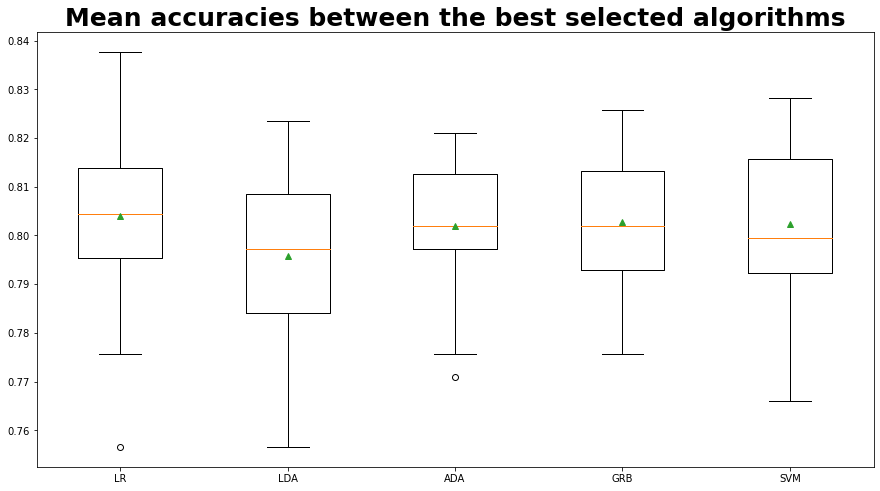

In [88]:
plt.figure(figsize = (15, 8))
plt.grid(False)
plt.title("Mean accuracies between the best selected algorithms", fontsize = 25, fontweight = 'bold')
plt.boxplot([scores1, scores2, scores3, scores4, scores5], labels=[model1_name, model2_name, model3_name, model4_name, model5_name], 
            showmeans=True)
plt.show()

### Hypothesis testing: pairwise comparison

In [89]:
from mlxtend.evaluate import paired_ttest_5x2cv
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model2,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model1} and {model2} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model1} and {model2} is not significantly different.")

The P-value is = 0.789
The t-statistics is = 0.283
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LogisticRegression(max_iter=1000) and LinearDiscriminantAnalysis() is not significantly different.


In [90]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model3,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model1} and {model3} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model1} and {model3} is not significantly different.")

The P-value is = 0.955
The t-statistics is = -0.059
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LogisticRegression(max_iter=1000) and AdaBoostClassifier(random_state=1) is not significantly different.


In [91]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model4,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model1} and {model4} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model1} and {model4} is not significantly different.")

The P-value is = 0.409
The t-statistics is = 0.900
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LogisticRegression(max_iter=1000) and GradientBoostingClassifier(random_state=1) is not significantly different.


In [92]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model5,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model1} and {model5} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model1} and {model5} is not significantly different.")

The P-value is = 0.443
The t-statistics is = 0.833
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LogisticRegression(max_iter=1000) and SVC() is not significantly different.


In [93]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model2, 
                          estimator2=model3,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model2} and {model3} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model2} and {model3} is not significantly different.")

The P-value is = 0.785
The t-statistics is = -0.288
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LinearDiscriminantAnalysis() and AdaBoostClassifier(random_state=1) is not significantly different.


In [94]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model2, 
                          estimator2=model4,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model2} and {model4} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model2} and {model4} is not significantly different.")

The P-value is = 0.264
The t-statistics is = 1.256
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LinearDiscriminantAnalysis() and GradientBoostingClassifier(random_state=1) is not significantly different.


In [95]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model2, 
                          estimator2=model5,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model2} and {model5} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model2} and {model5} is not significantly different.")

The P-value is = 0.293
The t-statistics is = 1.176
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models LinearDiscriminantAnalysis() and SVC() is not significantly different.


In [96]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model3, 
                          estimator2=model4,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model3} and {model4} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model3} and {model4} is not significantly different.")

The P-value is = 0.196
The t-statistics is = 1.490
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models AdaBoostClassifier(random_state=1) and GradientBoostingClassifier(random_state=1) is not significantly different.


In [97]:
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model3, 
                          estimator2=model5,
                          X=X_train, 
                          y=y_train, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print(f"Since p<0.05, We can reject the null-hypothesis that models {model3} and {model5} perform equally well on this dataset. We may conclude that the algorithms are significantly different.")
else:
    print(f"Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models {model3} and {model5} is not significantly different.")

The P-value is = 0.471
The t-statistics is = 0.780
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the models AdaBoostClassifier(random_state=1) and SVC() is not significantly different.


### ANOVA on all compared algorithms

In [98]:
# One-way ANOVA on all the algorithms

from scipy.stats import f_oneway

result_anova = f_oneway(scores1, scores2, scores3, scores4, scores5)
print(result_anova)

if result_anova[1] <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis that all models perform equally well on this dataset. We may conclude that the algorithms are significantly different.')
else:
    print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the algorithms is not significantly different.')

F_onewayResult(statistic=1.3445851279124066, pvalue=0.2562730407608212)
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the algorithms is not significantly different.


<a name='C6'></a>
## <font color='darkblue'>__Hyperparameter tuning__</font>

#### Logistic Regression

##### Randomized Search

In [99]:
# Create a Logistic Regression Instance
lr = LogisticRegression()

# Hyperparameter Optimization
lr_random_search = {'penalty': ['l2'],
                    'C': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1, 5, 10, 100],
                    'max_iter': [1000000]
                    }

# Run the randomized search
clf_lr = RandomizedSearchCV(estimator=lr,
                            param_distributions=lr_random_search,
                            cv=10,
                            scoring=f1_scorer,
                            n_iter = 10,
                            verbose = 1,
                            random_state = 1,
                            n_jobs = -1)

search_lr = clf_lr.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


In [100]:
pd.set_option('max_colwidth', None)
results_lr = pd.DataFrame(search_lr.cv_results_)
results_lr = results_lr[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_lr

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
2,"{'penalty': 'l2', 'max_iter': 1000000, 'C': 0.1}",1,0.592222,0.055637,0.588832,0.582160,0.633663,0.611650,0.620000
3,"{'penalty': 'l2', 'max_iter': 1000000, 'C': 0.2}",2,0.591614,0.053119,0.592965,0.582160,0.620000,0.611650,0.613065
4,"{'penalty': 'l2', 'max_iter': 1000000, 'C': 0.3}",3,0.591120,0.051749,0.590000,0.582160,0.613065,0.611650,0.613065
5,"{'penalty': 'l2', 'max_iter': 1000000, 'C': 0.5}",4,0.591073,0.050676,0.597015,0.582160,0.613065,0.604878,0.613065
6,"{'penalty': 'l2', 'max_iter': 1000000, 'C': 1}",5,0.590457,0.050097,0.597015,0.582160,0.613065,0.604878,0.613065
7,"{'penalty': 'l2', 'max_iter': 1000000, 'C': 5}",6,0.589938,0.050471,0.597015,0.582160,0.613065,0.601942,0.616162
8,"{'penalty': 'l2', 'max_iter': 1000000, 'C': 10}",6,0.589938,0.050471,0.597015,0.582160,0.613065,0.601942,0.616162
9,"{'penalty': 'l2', 'max_iter': 1000000, 'C': 100}",8,0.589287,0.049164,0.597015,0.582160,0.613065,0.601942,0.616162
1,"{'penalty': 'l2', 'max_iter': 1000000, 'C': 0.01}",9,0.568509,0.057610,0.543478,0.549020,0.614583,0.581633,0.607330
0,"{'penalty': 'l2', 'max_iter': 1000000, 'C': 0.001}",10,0.239387,0.040181,0.218750,0.281481,0.259542,0.201550,0.253731


#### Random Forest

In [101]:
# Setup parameters
n_estimators = [100, 200, 500, 1000, 1500, 2000, 5000]
max_features = ['log2', 'auto', 'sqrt']
max_depth = [2, 5, 10, 50, 80, 100]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4, 8]
bootstrap = [True, False]
criterion = ['entropy', 'gini']


# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Hyperparameter Optimization
rf_random_search = {'n_estimators': n_estimators, 
                    'max_features': max_features, 
                    'criterion': criterion,
                    'max_depth': max_depth, 
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                    }


# Run Randomized Serch
clf_rf = RandomizedSearchCV(estimator=rf,
                           param_distributions=rf_random_search,
                           cv=10,
                           n_iter=15,
                           scoring=f1_scorer,
                           verbose = 3,
                           n_jobs = -1)                         

search_rf = clf_rf.fit(X_train, y_train)


Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.0min finished


In [102]:
pd.set_option('max_colwidth', None)
results_rf = pd.DataFrame(search_rf.cv_results_)
results_rf = results_rf[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_rf

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
3,"{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': True}",1,0.574506,0.051527,0.618557,0.565657,0.565445,0.600000,0.590674
9,"{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': True}",2,0.571722,0.052489,0.597938,0.572864,0.575916,0.600985,0.572917
11,"{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 80, 'criterion': 'gini', 'bootstrap': False}",3,0.570584,0.047413,0.602041,0.561224,0.580311,0.585859,0.568421
7,"{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'gini', 'bootstrap': True}",4,0.570547,0.051095,0.596859,0.556701,0.580311,0.603960,0.580311
13,"{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'gini', 'bootstrap': False}",5,0.569647,0.039806,0.594872,0.543590,0.581633,0.603015,0.572917
10,"{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'gini', 'bootstrap': True}",6,0.569006,0.040073,0.571429,0.560000,0.585859,0.574359,0.575916
5,"{'n_estimators': 1500, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'gini', 'bootstrap': False}",7,0.565513,0.045374,0.580311,0.548223,0.584615,0.597015,0.571429
14,"{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 80, 'criterion': 'gini', 'bootstrap': False}",8,0.564884,0.042578,0.577320,0.558376,0.584615,0.592965,0.575916
12,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 80, 'criterion': 'entropy', 'bootstrap': True}",9,0.564469,0.040199,0.569948,0.572816,0.588832,0.600985,0.547368
6,"{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': False}",10,0.560215,0.039271,0.548223,0.554455,0.600985,0.562814,0.546392


#### Linear Discriminant Analysis

In [103]:
# Create a Linear Discriminant Analysis Instance
ld = LinearDiscriminantAnalysis()

# Hyperparameter Optimization
ld_random_search = {'solver': ['lsqr', 'eigen'],
                    'shrinkage': ['auto', 0.01, 0.05, 0.5, 1, None],
                    'n_components': [-1],
                    'store_covariance': [True, False]
                    }

# Run the Randomized search
clf_ld = RandomizedSearchCV(estimator=ld, 
                            param_distributions=ld_random_search,
                            cv=10,
                            scoring=f1_scorer,
                            verbose = 3,
                            n_jobs = -1)

search_ld = clf_ld.fit(X_train, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [104]:
pd.set_option('max_colwidth', None)
results_ld = pd.DataFrame(search_ld.cv_results_)
results_ld = results_ld[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_ld

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'store_covariance': False, 'solver': 'eigen', 'shrinkage': 0.5, 'n_components': -1}",1,0.630002,0.037105,0.596639,0.609756,0.686441,0.633333,0.641026
5,"{'store_covariance': False, 'solver': 'lsqr', 'shrinkage': 0.5, 'n_components': -1}",1,0.630002,0.037105,0.596639,0.609756,0.686441,0.633333,0.641026
7,"{'store_covariance': True, 'solver': 'eigen', 'shrinkage': 1, 'n_components': -1}",3,0.620846,0.020827,0.614815,0.609319,0.639098,0.615385,0.631970
1,"{'store_covariance': False, 'solver': 'eigen', 'shrinkage': 0.05, 'n_components': -1}",4,0.600920,0.046828,0.585366,0.616071,0.654028,0.592593,0.625000
2,"{'store_covariance': False, 'solver': 'eigen', 'shrinkage': 'auto', 'n_components': -1}",5,0.600084,0.048723,0.587065,0.603604,0.654028,0.591549,0.628019
4,"{'store_covariance': True, 'solver': 'eigen', 'shrinkage': 'auto', 'n_components': -1}",5,0.600084,0.048723,0.587065,0.603604,0.654028,0.591549,0.628019
6,"{'store_covariance': True, 'solver': 'lsqr', 'shrinkage': 'auto', 'n_components': -1}",5,0.600084,0.048723,0.587065,0.603604,0.654028,0.591549,0.628019
3,"{'store_covariance': True, 'solver': 'lsqr', 'shrinkage': 0.01, 'n_components': -1}",8,0.597493,0.048875,0.580000,0.603604,0.654028,0.584906,0.621359
9,"{'store_covariance': False, 'solver': 'lsqr', 'shrinkage': 0.01, 'n_components': -1}",8,0.597493,0.048875,0.580000,0.603604,0.654028,0.584906,0.621359
8,"{'store_covariance': False, 'solver': 'lsqr', 'shrinkage': None, 'n_components': -1}",10,0.594534,0.048815,0.577114,0.603604,0.654028,0.578199,0.614634


#### Ada Boost Classifier

In [105]:
n_estimators = [50, 100, 200, 500, 1000, 1500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
algorithm = ['SAMME', 'SAMME.R']


# Create an Ada Boost Instance
adb = AdaBoostClassifier()

# Hyperparameter Optimization
adb_random_search = {'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'algorithm': algorithm,
                    'random_state': [0]
                    }

# Run the Randomized search
clf_adb = RandomizedSearchCV(estimator=adb, 
                             param_distributions=adb_random_search,
                             cv=10,
                             scoring=f1_scorer,
                             verbose = 3,
                             n_jobs = -1)

search_adb = clf_adb.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


In [106]:
pd.set_option('max_colwidth', None)
results_adb = pd.DataFrame(search_adb.cv_results_)
results_adb = results_adb[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_adb

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'random_state': 0, 'n_estimators': 200, 'learning_rate': 0.3, 'algorithm': 'SAMME.R'}",1,0.589592,0.042283,0.610837,0.594059,0.592965,0.631068,0.577114
3,"{'random_state': 0, 'n_estimators': 1000, 'learning_rate': 0.5, 'algorithm': 'SAMME'}",2,0.587652,0.045973,0.595122,0.585366,0.570000,0.627451,0.603015
1,"{'random_state': 0, 'n_estimators': 1500, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'}",3,0.587135,0.042536,0.610000,0.578431,0.584615,0.627451,0.591133
5,"{'random_state': 0, 'n_estimators': 500, 'learning_rate': 0.3, 'algorithm': 'SAMME.R'}",4,0.586765,0.040655,0.610000,0.588235,0.574359,0.617647,0.581281
4,"{'random_state': 0, 'n_estimators': 1500, 'learning_rate': 0.2, 'algorithm': 'SAMME.R'}",5,0.582701,0.044376,0.610000,0.579710,0.572864,0.604878,0.588235
2,"{'random_state': 0, 'n_estimators': 50, 'learning_rate': 0.3, 'algorithm': 'SAMME.R'}",6,0.577655,0.055088,0.610000,0.572864,0.562500,0.610837,0.574359
8,"{'random_state': 0, 'n_estimators': 1500, 'learning_rate': 0.3, 'algorithm': 'SAMME'}",7,0.574131,0.052869,0.597938,0.565657,0.559585,0.613861,0.577320
9,"{'random_state': 0, 'n_estimators': 1500, 'learning_rate': 0.2, 'algorithm': 'SAMME'}",8,0.568820,0.052656,0.586387,0.549223,0.562500,0.620000,0.571429
7,"{'random_state': 0, 'n_estimators': 200, 'learning_rate': 0.05, 'algorithm': 'SAMME.R'}",9,0.559479,0.054315,0.575916,0.554974,0.554974,0.607330,0.569892
6,"{'random_state': 0, 'n_estimators': 500, 'learning_rate': 0.05, 'algorithm': 'SAMME'}",10,0.499572,0.050072,0.494253,0.505376,0.502857,0.494382,0.500000


#### Gradient Boosting Classifier

In [107]:
n_estimators = [50, 100, 200, 500, 1000, 1500, 2000]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
max_features = ['log2', 'auto', 'sqrt']
max_depth = [2, 5, 10, 50, 80, 100]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4, 8]
criterion = ['friedman_mse', 'mse', 'mae']
n_iter_no_change = [100] # adding the option of early stopping, otherwise runs for 75min and the performance is not necessarily better...

# Create a Gradient Boosting Classifier Instance
gdb = GradientBoostingClassifier()

# Hyperparameter Optimization
gdb_random_search = {'n_estimators': n_estimators,
                     'learning_rate': learning_rate,
                     'max_features': max_features,
                     'max_depth': max_depth,
                     'min_samples_split': min_samples_split,
                     'min_samples_leaf': min_samples_leaf,
                     'criterion': criterion,
                     'n_iter_no_change': n_iter_no_change
                     }

# Run the Randomized search
clf_gdb = RandomizedSearchCV(estimator=gdb, 
                             param_distributions=gdb_random_search,
                             cv=10,
                             scoring=f1_scorer,
                             verbose = 3,
                             n_jobs = -1)

search_gdb = clf_gdb.fit(X_train, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.5min finished


In [108]:
pd.set_option('max_colwidth', None)
results_gdb = pd.DataFrame(search_gdb.cv_results_)
results_gdb = results_gdb[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_gdb

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
1,"{'n_iter_no_change': 100, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1, 'criterion': 'mse'}",1,0.571949,0.050998,0.571429,0.581281,0.567010,0.607843,0.581281
0,"{'n_iter_no_change': 100, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 2, 'learning_rate': 0.05, 'criterion': 'mae'}",2,0.557616,0.050624,0.529730,0.568528,0.562500,0.598985,0.581633
3,"{'n_iter_no_change': 100, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'learning_rate': 0.3, 'criterion': 'mse'}",3,0.549941,0.046226,0.525253,0.550725,0.580952,0.533981,0.558376
4,"{'n_iter_no_change': 100, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 10, 'learning_rate': 0.1, 'criterion': 'mse'}",4,0.547518,0.064101,0.512563,0.547264,0.552381,0.591133,0.512315
5,"{'n_iter_no_change': 100, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'learning_rate': 0.5, 'criterion': 'mae'}",5,0.545785,0.037892,0.587156,0.492891,0.565854,0.528302,0.559242
6,"{'n_iter_no_change': 100, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'learning_rate': 0.05, 'criterion': 'friedman_mse'}",6,0.539809,0.041088,0.534653,0.533981,0.570048,0.557214,0.497409
8,"{'n_iter_no_change': 100, 'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'learning_rate': 0.3, 'criterion': 'friedman_mse'}",7,0.539359,0.059011,0.500000,0.540000,0.550725,0.520408,0.564356
7,"{'n_iter_no_change': 100, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'learning_rate': 0.3, 'criterion': 'friedman_mse'}",8,0.529035,0.033134,0.527363,0.520000,0.538860,0.517766,0.507772
9,"{'n_iter_no_change': 100, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'learning_rate': 0.2, 'criterion': 'mae'}",9,0.527855,0.044242,0.517413,0.470000,0.575472,0.514019,0.530000
2,"{'n_iter_no_change': 100, 'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 2, 'learning_rate': 0.1, 'criterion': 'mae'}",10,0.478149,0.063653,0.530387,0.488889,0.494253,0.502857,0.476744


#### SVM Classifier

In [109]:
# Create a Support Vector Machine Classifier Instance
svm = SVC()

# Hyperparameter Optimization
svm_random_search = {'C': [1, 10, 100, 1000],
                     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                     'degree': [1, 2, 3, 5, 10, 100],
                     'gamma': [0.001, 0.0001],
                    }

# Run the grid search
clf_svm = RandomizedSearchCV(estimator=svm, 
                             param_distributions=svm_random_search,
                             cv=10,
                             scoring=f1_scorer,
                             verbose = 3,
                             n_jobs = -1)

search_svm = clf_svm.fit(X_train, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


In [110]:
pd.set_option('max_colwidth', None)
results_svm = pd.DataFrame(search_svm.cv_results_)
results_svm = results_svm[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_svm

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
8,"{'kernel': 'sigmoid', 'gamma': 0.001, 'degree': 2, 'C': 100}",1,0.574541,0.053961,0.546392,0.566038,0.616162,0.577114,0.623762
9,"{'kernel': 'linear', 'gamma': 0.001, 'degree': 2, 'C': 1000}",2,0.574258,0.053462,0.546392,0.559242,0.610000,0.574257,0.630542
1,"{'kernel': 'linear', 'gamma': 0.0001, 'degree': 100, 'C': 10}",3,0.572767,0.056194,0.543590,0.559242,0.616915,0.574257,0.630542
5,"{'kernel': 'linear', 'gamma': 0.0001, 'degree': 10, 'C': 10}",3,0.572767,0.056194,0.543590,0.559242,0.616915,0.574257,0.630542
7,"{'kernel': 'linear', 'gamma': 0.001, 'degree': 10, 'C': 10}",3,0.572767,0.056194,0.543590,0.559242,0.616915,0.574257,0.630542
0,"{'kernel': 'rbf', 'gamma': 0.0001, 'degree': 3, 'C': 1000}",6,0.572400,0.053852,0.556701,0.559242,0.619289,0.577114,0.616915
3,"{'kernel': 'poly', 'gamma': 0.001, 'degree': 1, 'C': 10}",7,0.571755,0.053148,0.565445,0.561905,0.636364,0.567164,0.605128
4,"{'kernel': 'sigmoid', 'gamma': 0.0001, 'degree': 2, 'C': 100}",7,0.571755,0.053148,0.565445,0.561905,0.636364,0.567164,0.605128
2,"{'kernel': 'poly', 'gamma': 0.0001, 'degree': 100, 'C': 1000}",9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"{'kernel': 'poly', 'gamma': 0.001, 'degree': 2, 'C': 10}",9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [111]:
# Putting the Dataframes with the hyperparameter-tuning results in a dictionary
hyper_tuning_random = {
    'LR': results_lr,
    'LDA': results_ld,
    'RFC': results_rf,
    'ADA': results_adb,
    'GDB': results_gdb,
    'SVM': results_svm
}

hyper_dict = {}
scores = []
names = []

for df_name, df in hyper_tuning_random.items():
    name = df_name
    names.append(name)
    score = df.iloc[0]['mean_test_score']
    scores.append(score)
    hyper_dict['name'] = names
    hyper_dict['score'] = scores
    
df_hyper_random = pd.DataFrame(hyper_dict).set_index('name')


In [112]:
df_hyper_random

,score
name,
LR,0.592222
LDA,0.630002
RFC,0.574506
ADA,0.589592
GDB,0.571949
SVM,0.574541


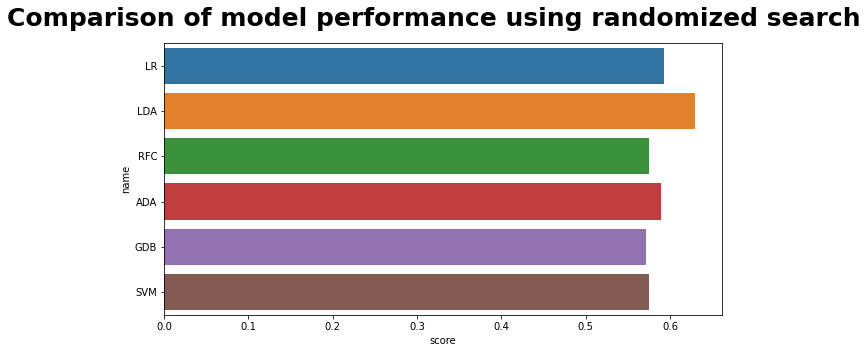

In [113]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='score', y=df_hyper_random.index, data=df_hyper_random)
plt.suptitle("Comparison of model performance using randomized search", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

#### Grid Search - LR

In [114]:
# Create a Logistic Regression Instance
lr_grid = LogisticRegression()

# Hyperparameter Optimization
lr_grid_search = {'penalty': ['l2'],
                  'C': [0.001, 0.01, 0.05, 0.15, 0.16, 0.18],
                  'max_iter': [1000000],
                  'random_state': [1]
                  }

# Run the grid search
clf_lr_grid = GridSearchCV(estimator=lr_grid, 
                           param_grid=lr_grid_search,
                           cv=5,
                           scoring=f1_scorer,
                           verbose = 3,
                           n_jobs = -1)

search_lr_grid = clf_lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


In [115]:
pd.set_option('max_colwidth', None)
results_lr_grid = pd.DataFrame(search_lr_grid.cv_results_)
results_lr_grid = results_lr_grid[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_lr_grid

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
3,"{'C': 0.15, 'max_iter': 1000000, 'penalty': 'l2', 'random_state': 1}",1,0.595184,0.016337,0.594203,0.614634,0.598039,0.603491,0.565553
4,"{'C': 0.16, 'max_iter': 1000000, 'penalty': 'l2', 'random_state': 1}",1,0.595184,0.016337,0.594203,0.614634,0.598039,0.603491,0.565553
5,"{'C': 0.18, 'max_iter': 1000000, 'penalty': 'l2', 'random_state': 1}",3,0.594507,0.015568,0.594203,0.611247,0.598039,0.603491,0.565553
2,"{'C': 0.05, 'max_iter': 1000000, 'penalty': 'l2', 'random_state': 1}",4,0.589993,0.023083,0.578431,0.617284,0.599010,0.604061,0.551181
1,"{'C': 0.01, 'max_iter': 1000000, 'penalty': 'l2', 'random_state': 1}",5,0.567507,0.023210,0.550129,0.597403,0.585242,0.571429,0.533333
0,"{'C': 0.001, 'max_iter': 1000000, 'penalty': 'l2', 'random_state': 1}",6,0.163045,0.031387,0.192000,0.147541,0.203125,0.156379,0.116183


#### Grid Search - LDA

In [116]:
# Create a Linear Discriminant Analysis Instance
ld_grid = LinearDiscriminantAnalysis()

# Hyperparameter Optimization
ld_grid_search = {'solver': ['lsqr'],
                  'shrinkage': [0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55],
                  'n_components': [-1],
                  'store_covariance': [True]
                  }

# Run the grid search
clf_ld_grid = GridSearchCV(estimator=ld_grid, 
                           param_grid=ld_grid_search,
                           cv=10,
                           scoring=f1_scorer,
                           verbose = 3,
                           n_jobs = -1)

search_ld_grid = clf_ld_grid.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished


In [117]:
pd.set_option('max_colwidth', None)
results_ld_grid = pd.DataFrame(search_ld_grid.cv_results_)
results_ld_grid = results_ld_grid[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_ld_grid

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
1,"{'n_components': -1, 'shrinkage': 0.5, 'solver': 'lsqr', 'store_covariance': True}",1,0.630002,0.037105,0.596639,0.609756,0.686441,0.633333,0.641026
5,"{'n_components': -1, 'shrinkage': 0.54, 'solver': 'lsqr', 'store_covariance': True}",2,0.629592,0.036311,0.598361,0.607287,0.680672,0.628099,0.641026
6,"{'n_components': -1, 'shrinkage': 0.55, 'solver': 'lsqr', 'store_covariance': True}",3,0.629021,0.034835,0.598361,0.612903,0.680672,0.628099,0.641026
4,"{'n_components': -1, 'shrinkage': 0.53, 'solver': 'lsqr', 'store_covariance': True}",4,0.628902,0.037671,0.592593,0.607287,0.686441,0.633333,0.641026
2,"{'n_components': -1, 'shrinkage': 0.51, 'solver': 'lsqr', 'store_covariance': True}",5,0.628734,0.038078,0.589212,0.609756,0.686441,0.633333,0.641026
3,"{'n_components': -1, 'shrinkage': 0.52, 'solver': 'lsqr', 'store_covariance': True}",6,0.628572,0.038237,0.592593,0.607287,0.686441,0.633333,0.641026
0,"{'n_components': -1, 'shrinkage': 0.49, 'solver': 'lsqr', 'store_covariance': True}",7,0.627904,0.036113,0.596639,0.609756,0.686441,0.633333,0.641026


#### Grid Search - ADA

In [118]:
# Create an Ada Boost Instance
adb_grid = AdaBoostClassifier()

# Hyperparameter Optimization
adb_grid_search = {'n_estimators': [300, 400, 500, 550, 600, 650, 700],
                   'learning_rate': [0.1, 0.2, 0.3, 0.5],
                   'algorithm': ['SAMME.R'],
                   'random_state': [0]
                   }

# Run the grid search
clf_adb_grid = GridSearchCV(estimator=adb_grid, 
                            param_grid=adb_grid_search,
                            cv=5,
                            scoring=f1_scorer,
                            verbose = 3,
                            n_jobs = -1)

search_adb_grid = clf_adb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.1min finished


In [119]:
pd.set_option('max_colwidth', None)
results_adb_grid = pd.DataFrame(search_adb_grid.cv_results_)
results_adb_grid = results_adb_grid[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_adb_grid

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
3,"{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 550, 'random_state': 0}",1,0.589291,0.017154,0.601467,0.605000,0.574209,0.602469,0.563307
4,"{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 600, 'random_state': 0}",2,0.588188,0.018821,0.601467,0.603491,0.577670,0.602469,0.555844
7,"{'algorithm': 'SAMME.R', 'learning_rate': 0.2, 'n_estimators': 300, 'random_state': 0}",3,0.587744,0.019673,0.601467,0.603491,0.573494,0.604423,0.555844
12,"{'algorithm': 'SAMME.R', 'learning_rate': 0.2, 'n_estimators': 650, 'random_state': 0}",4,0.587659,0.015312,0.598039,0.600000,0.579710,0.599509,0.561039
9,"{'algorithm': 'SAMME.R', 'learning_rate': 0.2, 'n_estimators': 500, 'random_state': 0}",5,0.587483,0.016587,0.601467,0.601990,0.574879,0.598039,0.561039
10,"{'algorithm': 'SAMME.R', 'learning_rate': 0.2, 'n_estimators': 550, 'random_state': 0}",6,0.587299,0.017131,0.599509,0.603015,0.574879,0.599509,0.559585
2,"{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 0}",7,0.587064,0.017297,0.599509,0.605000,0.574209,0.597015,0.559585
11,"{'algorithm': 'SAMME.R', 'learning_rate': 0.2, 'n_estimators': 600, 'random_state': 0}",8,0.586994,0.016184,0.599509,0.601504,0.574879,0.598039,0.561039
14,"{'algorithm': 'SAMME.R', 'learning_rate': 0.3, 'n_estimators': 300, 'random_state': 0}",9,0.586842,0.020288,0.600985,0.608911,0.565217,0.599509,0.559585
8,"{'algorithm': 'SAMME.R', 'learning_rate': 0.2, 'n_estimators': 400, 'random_state': 0}",10,0.586706,0.018558,0.596577,0.606965,0.567961,0.600985,0.561039


In [120]:
# Putting the Dataframes of the grid search results in a dictionary
hyper_tuning_grid = {
    'LR': results_lr_grid,
    'LDA': results_ld_grid,
    'ADA': results_adb_grid
}
    

hyper_dict_grid = {}
scores_grid = []
names_grid = []

for df_name, df in hyper_tuning_grid.items():
    name = df_name
    names_grid.append(name)
    score = df.iloc[0]['mean_test_score']
    scores_grid.append(score)
    hyper_dict_grid['name'] = names_grid
    hyper_dict_grid['score'] = scores_grid
    
df_hyper_grid = pd.DataFrame(hyper_dict_grid).set_index('name')


In [121]:
df_hyper_grid

,score
name,
LR,0.595184
LDA,0.630002
ADA,0.589291


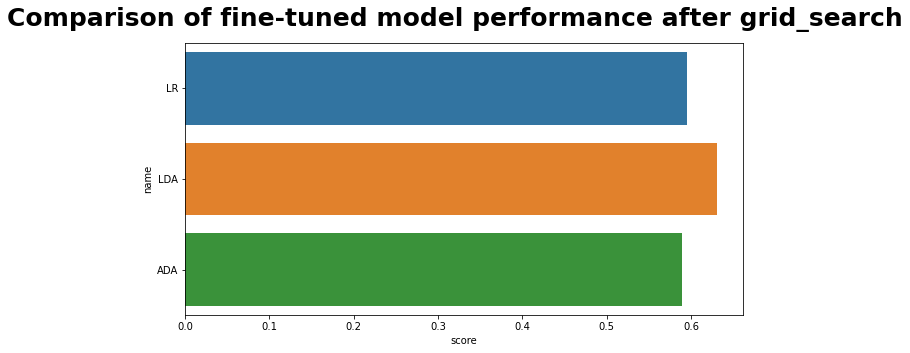

In [122]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='score', y=df_hyper_grid.index, data=df_hyper_grid)
plt.suptitle("Comparison of fine-tuned model performance after grid_search", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

<a name='C7'></a>
## <font color='darkblue'>__Compare model performance__</font>

              precision    recall  f1-score   support

          No       0.83      0.90      0.87      1320
         Yes       0.65      0.50      0.57       476

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.72      1796
weighted avg       0.79      0.80      0.79      1796



<AxesSubplot:>

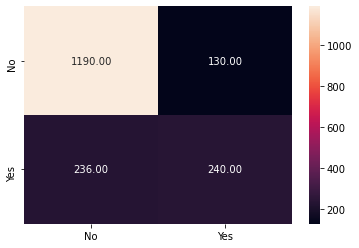

In [123]:
model1 = search_lr_grid.best_estimator_
class_labels = model1.classes_

model1.fit(X_train, y_train)

predictions = model1.predict(X_test)
print(classification_report(y_test, predictions))
cm_lr = pd.DataFrame(confusion_matrix(y_test, predictions), columns=class_labels, index=class_labels)
sns.heatmap(cm_lr, annot=True, fmt='.2f')

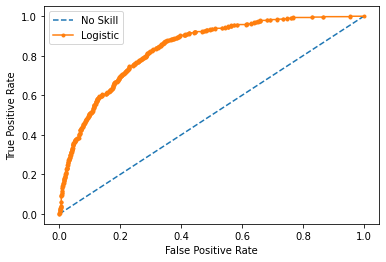

Logistic: ROC AUC = 0.84


In [124]:
probs_lr = model1.predict_proba(X_test)
probs_lr = probs_lr[: , 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_encoded, probs_lr)
lr_auc = roc_auc_score(y_test, probs_lr)

plt.plot([0,1], [0,1], linestyle = '--', label='No Skill')
plt.plot(fpr_lr, tpr_lr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f"Logistic: ROC AUC = {lr_auc:.2f}")

              precision    recall  f1-score   support

          No       0.86      0.84      0.85      1320
         Yes       0.58      0.63      0.61       476

    accuracy                           0.78      1796
   macro avg       0.72      0.74      0.73      1796
weighted avg       0.79      0.78      0.79      1796



<AxesSubplot:>

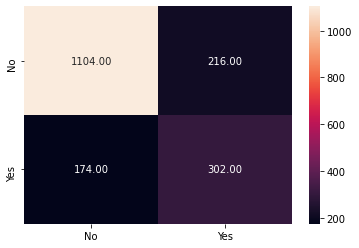

In [125]:
model2 = search_ld_grid.best_estimator_
class_labels = model2.classes_

model2.fit(X_train, y_train)

predictions = model2.predict(X_test)
print(classification_report(y_test, predictions))
cm_ld = pd.DataFrame(confusion_matrix(y_test, predictions), columns=class_labels, index=class_labels)
sns.heatmap(cm_ld, annot=True, fmt='.2f')

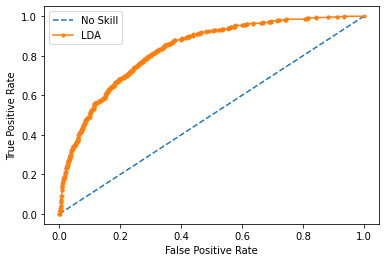

LDA: ROC AUC = 0.83


In [126]:
probs_ld = model2.predict_proba(X_test)
probs_ld = probs_ld[: , 1]
fpr_ld, tpr_ld, thresholds_ld = roc_curve(y_test_encoded, probs_ld)
ld_auc = roc_auc_score(y_test, probs_ld)

plt.plot([0,1], [0,1], linestyle = '--', label='No Skill')
plt.plot(fpr_ld, tpr_ld, marker='.', label='LDA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f"LDA: ROC AUC = {ld_auc:.2f}")

              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1320
         Yes       0.66      0.53      0.58       476

    accuracy                           0.80      1796
   macro avg       0.75      0.71      0.73      1796
weighted avg       0.79      0.80      0.79      1796



<AxesSubplot:>

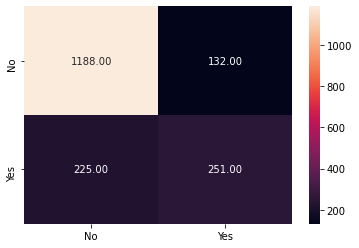

In [127]:
model3 = search_adb_grid.best_estimator_
class_labels = model3.classes_

model3.fit(X_train, y_train)

predictions = model3.predict(X_test)
print(classification_report(y_test, predictions))
cm_adb = pd.DataFrame(confusion_matrix(y_test, predictions), columns=class_labels, index=class_labels)
sns.heatmap(cm_adb, annot=True, fmt='.2f')

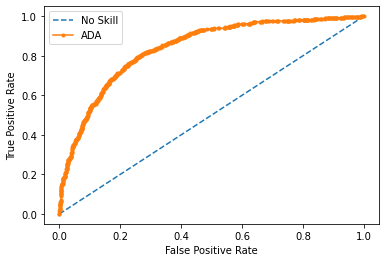

ADA: ROC AUC = 0.84


In [128]:
probs_adb = model3.predict_proba(X_test)
probs_adb = probs_adb[: , 1]
fpr_adb, tpr_adb, thresholds_adb = roc_curve(y_test_encoded, probs_adb)
adb_auc = roc_auc_score(y_test, probs_adb)

plt.plot([0,1], [0,1], linestyle = '--', label='No Skill')
plt.plot(fpr_adb, tpr_adb, marker='.', label='ADA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f"ADA: ROC AUC = {adb_auc:.2f}")

<a name='C8'></a>
## <font color='darkblue'>__Select final model and save model artifacts__</font>

In [129]:
# Selected model: Linear Discriminant Analysis
final_model = model2

In [130]:
model_artifacts = {
    'cat_init_features': cat_cols.values,
    'num_init_features': num_cols.values,
    'cat_ohe_features': cat_ohe_cols,
    'column_names_order': final_dataset_columns,
    'cat_imputer': cat_imputer,
    'dummy_encoder': cat_dummy_encoder,
    'num_imputer': knn_imp,
    'scaler': scaler,
    'final_model': final_model,
}

### Save model artifacts

In [131]:
import dill

In [132]:
with open("../ml_app/saved_models/churn_ldisc_artifacts.pkl", "wb") as dill_file:
    dill.dump(model_artifacts, dill_file)

<a name='C9'></a>
## <font color='darkblue'>__Model Interpretation__</font>

### Model Interpretation with SHAP

In [133]:
shap.initjs()

In [134]:
X_train_num_reverse = pd.DataFrame(scaler.inverse_transform(X_train_num), columns=num_cols)
X_train_new = pd.concat([X_train_cat_ohe, X_train_num_reverse], axis=1)
X_train_new = X_train_new[final_dataset_columns]


X_test_num_reverse = pd.DataFrame(scaler.inverse_transform(X_test_num), columns=num_cols)
X_test_new = pd.concat([X_test_cat_ohe, X_test_num_reverse], axis=1)
X_test_new = X_test_new[final_dataset_columns]

In [135]:
shap_explainer = shap.KernelExplainer(final_model.predict_proba, shap.sample(X_train, 100))
shap_values = shap_explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(shap_explainer.expected_value[0], shap_values[0], X_test_new.iloc[0,:])

In [136]:
X_test_new.head(3)

,MonthlyCharges,TotalCharges,tenure,PhoneService_No,PhoneService_Yes,TechSupport_No,TechSupport_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling_No,PaperlessBilling_Yes,StreamingTV_No,StreamingTV_Yes,OnlineBackup_No,OnlineBackup_Yes,OnlineSecurity_No,OnlineSecurity_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,MultipleLines_No,MultipleLines_Yes,DeviceProtection_No,DeviceProtection_Yes,Dependents_No,Dependents_Yes,SeniorCitizen_No,SeniorCitizen_Yes,StreamingMovies_No,StreamingMovies_Yes,Partner_No,Partner_Yes
0,49.90,49.9,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,74.10,5222.3,70.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
2,104.65,6889.8,64.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [137]:
pd.DataFrame(shap_values, columns=X_test_new.columns).head(3)

,MonthlyCharges,TotalCharges,tenure,PhoneService_No,PhoneService_Yes,TechSupport_No,TechSupport_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling_No,PaperlessBilling_Yes,StreamingTV_No,StreamingTV_Yes,OnlineBackup_No,OnlineBackup_Yes,OnlineSecurity_No,OnlineSecurity_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,MultipleLines_No,MultipleLines_Yes,DeviceProtection_No,DeviceProtection_Yes,Dependents_No,Dependents_Yes,SeniorCitizen_No,SeniorCitizen_Yes,StreamingMovies_No,StreamingMovies_Yes,Partner_No,Partner_Yes
0,0.049735,-0.084326,-0.14217,0.0,0.0,0.033666,0.022062,-0.004632,-0.007769,0.034142,0.016351,-0.014659,-0.015815,-0.005668,0.009126,-0.03196,-0.007858,-0.038118,-0.010361,0.036312,0.042075,-0.008001,0.003044,0.003469,-0.038065,-0.008125,-0.009963,0.017501,0.009652,-0.021156,-0.002224,0.012406,0.011536,0.008809,0.009694,0.0,0.012771,-0.004927,-0.005072
1,-0.049735,0.084326,0.14217,0.0,0.0,-0.033666,-0.022062,0.004632,0.007769,-0.034142,-0.016351,0.014659,0.015815,0.005668,-0.009126,0.03196,0.007858,0.038118,0.010361,-0.036312,-0.042075,0.008001,-0.003044,-0.003469,0.038065,0.008125,0.009963,-0.017501,-0.009652,0.021156,0.002224,-0.012406,-0.011536,-0.008809,-0.009694,0.0,-0.012771,0.004927,0.005072


In [138]:
shap_explainer.expected_value

array([0.72355545, 0.27644455])

In [139]:
pred_lda = final_model.predict(X_test)
y_test.iloc[150], pred_lda[150]

('No', 'No')

### Model Interpretation with LIME

In [140]:
lime_explainer = LimeTabularExplainer(np.array(X_train_new),
                    feature_names=X_train_new.columns, 
                    class_names=[0, 1], 
                    categorical_features = cat_ohe_cols,                               
                    verbose=True, mode='classification')

Intercept -0.00731875895982197
Prediction_local [0.06104711]
Right: 0.15805001197854007


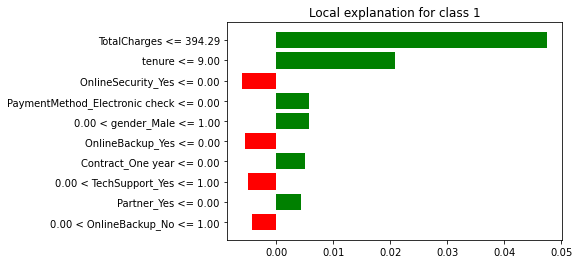

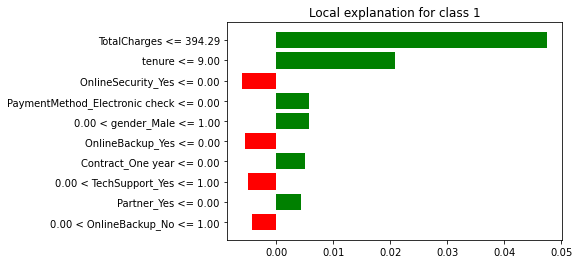

In [141]:
exp = lime_explainer.explain_instance(X_test_new.iloc[0], 
     final_model.predict_proba, num_features=10)
exp.as_pyplot_figure()

<a name='C10'></a>
## <font color='darkblue'>__Predict and draw conclusions__</font>

### Load Data

In [142]:
df = pd.read_csv('../datasets/telecom_users.csv')
final_columns = set(df.columns) - set(['Unnamed: 0'])
final_columns = list(final_columns)
df = df[final_columns]

In [143]:
# Impute Data and make necessary conversions
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: "No", 1: "Yes"})
df['TotalCharges'] = df['TotalCharges'].replace({" ": np.nan})
df['TotalCharges'] = np.where(df['TotalCharges'].isnull(), df['MonthlyCharges'], df['TotalCharges'])
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['tenure'] = df['tenure'].replace({0: 1})

In [144]:
X_check = df.drop(columns=['Churn', 'customerID'])
y_check = df['Churn']

X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(X_check, y_check, test_size=0.3, random_state=42, stratify=y)

In [145]:
X_test_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1796 entries, 3564 to 4851
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MonthlyCharges    1796 non-null   float64
 1   PhoneService      1796 non-null   object 
 2   TechSupport       1796 non-null   object 
 3   PaymentMethod     1796 non-null   object 
 4   PaperlessBilling  1796 non-null   object 
 5   StreamingTV       1796 non-null   object 
 6   OnlineBackup      1796 non-null   object 
 7   OnlineSecurity    1796 non-null   object 
 8   InternetService   1796 non-null   object 
 9   gender            1796 non-null   object 
 10  Contract          1796 non-null   object 
 11  MultipleLines     1796 non-null   object 
 12  TotalCharges      1796 non-null   float64
 13  DeviceProtection  1796 non-null   object 
 14  Dependents        1796 non-null   object 
 15  SeniorCitizen     1796 non-null   object 
 16  StreamingMovies   1796 non-null   objec

### Load saved Model Artifacts

In [146]:
with open("../ml_app/saved_models/churn_ldisc_artifacts.pkl", "rb") as dill_infile:
    ldisc_model_artifacts = dill.load(dill_infile)

In [147]:
ldisc_model_artifacts

{'cat_init_features': array(['PhoneService', 'TechSupport', 'PaymentMethod', 'PaperlessBilling',
        'StreamingTV', 'OnlineBackup', 'OnlineSecurity', 'InternetService',
        'gender', 'Contract', 'MultipleLines', 'DeviceProtection',
        'Dependents', 'SeniorCitizen', 'StreamingMovies', 'Partner'],
       dtype=object),
 'num_init_features': array(['MonthlyCharges', 'TotalCharges', 'tenure'], dtype=object),
 'cat_ohe_features': array(['PhoneService_No', 'PhoneService_Yes', 'TechSupport_No',
        'TechSupport_No internet service', 'TechSupport_Yes',
        'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        'PaperlessBilling_No', 'PaperlessBilling_Yes', 'StreamingTV_No',
        'StreamingTV_No internet service', 'StreamingTV_Yes',
        'OnlineBackup_No', 'OnlineBackup_No internet service',
        'OnlineBackup_Yes', 'OnlineSecurity_No',
        'Onli

In [148]:
categorical_features_init = ldisc_model_artifacts['cat_init_features']
categorical_features_ohe = ldisc_model_artifacts['cat_ohe_features']
numeric_features_init = ldisc_model_artifacts['num_init_features']
column_names = ldisc_model_artifacts['column_names_order']

categorical_imputer = ldisc_model_artifacts['cat_imputer']
categorical_ohe = ldisc_model_artifacts['dummy_encoder']

numeric_imputer = ldisc_model_artifacts['num_imputer']
st_scaler = ldisc_model_artifacts['scaler']

ml_model = ldisc_model_artifacts['final_model']

### Pre-processing and Feature Encoding

In [149]:
X_test_check_cat = X_test_check[categorical_features_init]
X_test_check_num = X_test_check[numeric_features_init]

X_test_check_cat = pd.DataFrame(categorical_imputer.transform(X_test_check_cat), 
                          columns=categorical_features_init)
X_test_check_cat_ohe = categorical_ohe.transform(X_test_check_cat).toarray()
X_test_check_cat_ohe = pd.DataFrame(X_test_check_cat_ohe, 
                               columns=categorical_features_ohe)

X_test_check_num = pd.DataFrame(numeric_imputer.transform(X_test_check_num), columns=numeric_features_init)
X_test_check_num = pd.DataFrame(st_scaler.transform(X_test_check_num), columns=numeric_features_init)


X_test_check = pd.concat([X_test_check_num, X_test_check_cat_ohe], axis=1)
X_test_check = X_test_check[column_names]
X_test_check.head(3)

,MonthlyCharges,TotalCharges,tenure,PhoneService_No,PhoneService_Yes,TechSupport_No,TechSupport_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling_No,PaperlessBilling_Yes,StreamingTV_No,StreamingTV_Yes,OnlineBackup_No,OnlineBackup_Yes,OnlineSecurity_No,OnlineSecurity_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,MultipleLines_No,MultipleLines_Yes,DeviceProtection_No,DeviceProtection_Yes,Dependents_No,Dependents_Yes,SeniorCitizen_No,SeniorCitizen_Yes,StreamingMovies_No,StreamingMovies_Yes,Partner_No,Partner_Yes
0,-0.489235,-0.983174,-1.281158,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.309314,1.294997,1.545103,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.317400,2.029444,1.299341,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [150]:
X_test_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   MonthlyCharges                           1796 non-null   float64
 1   TotalCharges                             1796 non-null   float64
 2   tenure                                   1796 non-null   float64
 3   PhoneService_No                          1796 non-null   float64
 4   PhoneService_Yes                         1796 non-null   float64
 5   TechSupport_No                           1796 non-null   float64
 6   TechSupport_Yes                          1796 non-null   float64
 7   PaymentMethod_Bank transfer (automatic)  1796 non-null   float64
 8   PaymentMethod_Credit card (automatic)    1796 non-null   float64
 9   PaymentMethod_Electronic check           1796 non-null   float64
 10  PaymentMethod_Mailed check               1796 no

### Make Prediction

In [151]:
predictions = ml_model.predict(X_test_check)
predictions

array(['No', 'No', 'No', ..., 'No', 'Yes', 'No'], dtype='<U3')

In [152]:
labels = ml_model.classes_

print(classification_report(y_test_check, predictions))
pd.DataFrame(confusion_matrix(y_test_check, predictions), columns=labels, index=labels)

              precision    recall  f1-score   support

          No       0.86      0.84      0.85      1320
         Yes       0.58      0.63      0.61       476

    accuracy                           0.78      1796
   macro avg       0.72      0.74      0.73      1796
weighted avg       0.79      0.78      0.79      1796



,No,Yes
No,1104,216
Yes,174,302


<a name='AML'></a>
## <font color='darkblue'>__Try AutoML Model recommendation__</font>

### Setup, Compare and Create Model

In [153]:
reg = setup(data=pd.concat([X_train, y_train], axis=1), 
            target = 'Churn', 
            session_id=13, 
            log_experiment=True, 
            experiment_name='churn1')

,Description,Value
0,session_id,13
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(5444, 40)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,36
8,Ordinal Features,False
9,High Cardinality Features,False


In [154]:
best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7392,0.4966,0.0000,0.0000,0.0000,0.0000,0.0000,0.2780
ridge,Ridge Classifier,0.7392,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0060
lda,Linear Discriminant Analysis,0.7392,0.4968,0.0000,0.0000,0.0000,0.0000,0.0000,0.0120
ada,Ada Boost Classifier,0.7337,0.4900,0.0079,0.2522,0.0151,-0.0033,-0.0067,0.0480
catboost,CatBoost Classifier,0.7296,0.4879,0.0222,0.2669,0.0409,0.0020,0.0032,0.8820
gbc,Gradient Boosting Classifier,0.7258,0.4896,0.0144,0.1873,0.0265,-0.0124,-0.0260,0.1080
svm,SVM - Linear Kernel,0.7255,0.0000,0.0458,0.0642,0.0534,0.0121,0.0082,0.0160
rf,Random Forest Classifier,0.7118,0.4814,0.0549,0.2545,0.0902,-0.0019,-0.0030,0.0780
lightgbm,Light Gradient Boosting Machine,0.7009,0.4799,0.0523,0.2082,0.0831,-0.0235,-0.0316,0.0460
xgboost,Extreme Gradient Boosting,0.6999,0.4904,0.0851,0.2647,0.1287,0.0025,0.0029,0.2760


In [155]:
lr_auto = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7372,0.4027,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7372,0.4485,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7372,0.5035,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7372,0.5094,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7406,0.5038,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7406,0.4454,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7406,0.5862,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7406,0.4594,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7406,0.4947,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.7397,0.5871,0.0000,0.0000,0.0000,0.0000,0.0000


In [156]:
lda_auto = create_model('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7372,0.4024,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7372,0.4486,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7372,0.5005,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7372,0.5087,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7406,0.5036,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7406,0.4449,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7406,0.5719,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7406,0.4500,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7406,0.4716,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.7397,0.5810,0.0000,0.0000,0.0000,0.0000,0.0000


### Tune Models

In [157]:
tuned_lr = tune_model(lr_auto, n_iter=50, optimize = 'f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5222,0.4048,0.3117,0.2162,0.2553,-0.0798,-0.0827
1,0.4881,0.4420,0.4026,0.2296,0.2925,-0.0635,-0.0697
2,0.5256,0.4930,0.4286,0.2578,0.3220,-0.0093,-0.0100
3,0.5904,0.5291,0.4545,0.3097,0.3684,0.0812,0.0845
4,0.5427,0.5030,0.3947,0.2542,0.3093,-0.0092,-0.0096
5,0.5188,0.4383,0.3158,0.2124,0.2540,-0.0815,-0.0850
6,0.5836,0.5829,0.5132,0.3145,0.3900,0.1008,0.1077
7,0.5222,0.4451,0.3553,0.2288,0.2784,-0.0543,-0.0573
8,0.5836,0.4999,0.3947,0.2830,0.3297,0.0394,0.0406
9,0.6301,0.5848,0.5132,0.3545,0.4194,0.1611,0.1670


In [158]:
tuned_lda = tune_model(lda_auto, n_iter=50, optimize = 'f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5973,0.5114,0.2208,0.2267,0.2237,-0.0481,-0.0481
1,0.5495,0.4559,0.3896,0.2609,0.3125,-0.0034,-0.0035
2,0.5768,0.4717,0.3377,0.2626,0.2955,-0.0003,-0.0003
3,0.6143,0.5357,0.2597,0.2632,0.2614,0.0005,0.0005
4,0.6041,0.5092,0.2632,0.2500,0.2564,-0.0131,-0.0131
5,0.5939,0.4669,0.2895,0.2529,0.2699,-0.0096,-0.0097
6,0.6075,0.5484,0.3421,0.2857,0.3114,0.0400,0.0403
7,0.6143,0.5354,0.2763,0.2658,0.2710,0.0089,0.0089
8,0.6451,0.5463,0.2368,0.2812,0.2571,0.0262,0.0264
9,0.6918,0.5937,0.3026,0.3833,0.3382,0.1410,0.1426


In [159]:
lr_auto

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [160]:
tuned_lr

LogisticRegression(C=0.038, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [161]:
lda_auto

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [162]:
tuned_lda

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=1,
                           solver='lsqr', store_covariance=False, tol=0.0001)

### Ensemble Model

In [163]:
en_lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7372,0.4027,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7372,0.4485,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7372,0.5035,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7372,0.5094,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7406,0.5038,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7406,0.4454,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7406,0.5862,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7406,0.4594,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7406,0.4947,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.7397,0.5871,0.0000,0.0000,0.0000,0.0000,0.0000


In [164]:
bagged_lr = ensemble_model(en_lr, n_estimators=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7372,0.4242,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7372,0.4531,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7372,0.5051,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7372,0.5266,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7406,0.5140,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7406,0.4375,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7406,0.5683,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7406,0.4544,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7406,0.4816,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.7397,0.5899,0.0000,0.0000,0.0000,0.0000,0.0000


In [165]:
boosted_lr = ensemble_model(en_lr, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7372,0.4336,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7372,0.4510,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7372,0.4711,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7372,0.5406,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7406,0.5055,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7406,0.4557,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7406,0.5780,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7406,0.4784,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7406,0.5263,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.7397,0.5925,0.0000,0.0000,0.0000,0.0000,0.0000


In [166]:
boosted_lr

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=1000,
                                                     multi_class='auto',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=13,
                                                     solver='lbfgs', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                   learning_rate=1.0, n_estimators=10, random_state=13)

### Analyze & Interpret Model - LR & LDA side-by-side

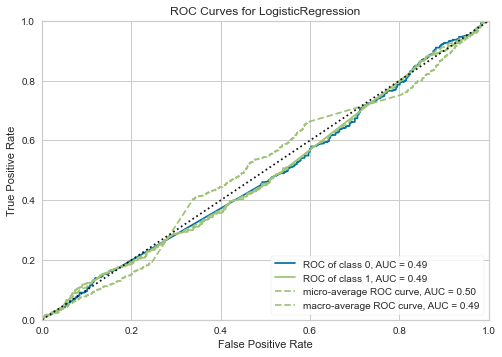

In [167]:
plot_model(tuned_lr)

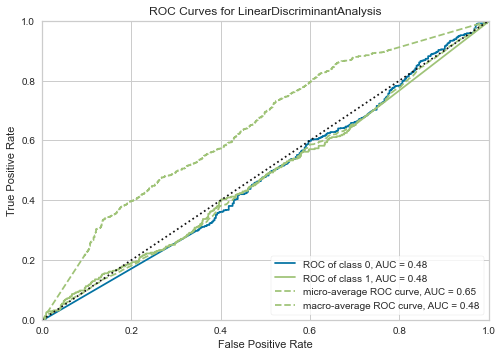

In [168]:
plot_model(tuned_lda)

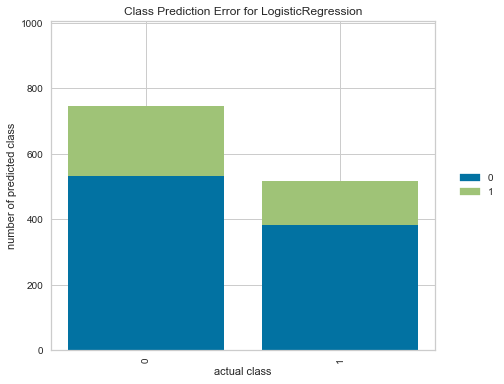

In [169]:
plot_model(tuned_lr, plot = 'error')

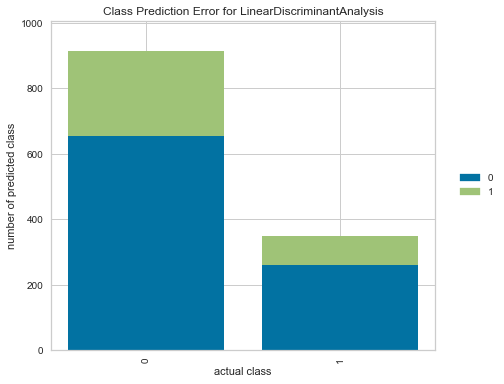

In [170]:
plot_model(tuned_lda, plot = 'error')

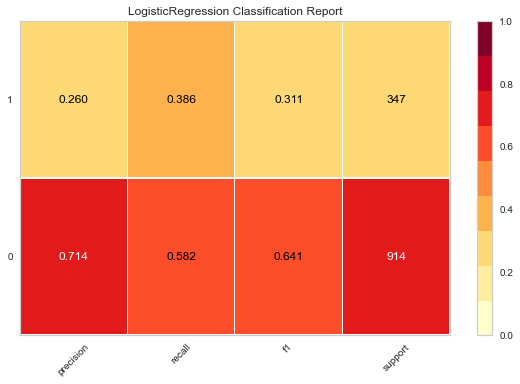

In [171]:
plot_model(tuned_lr, plot = 'class_report')

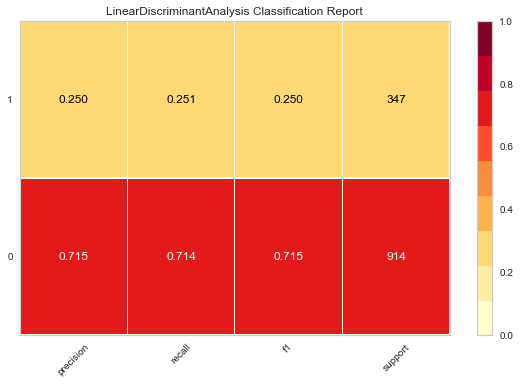

In [172]:
plot_model(tuned_lda, plot = 'class_report')

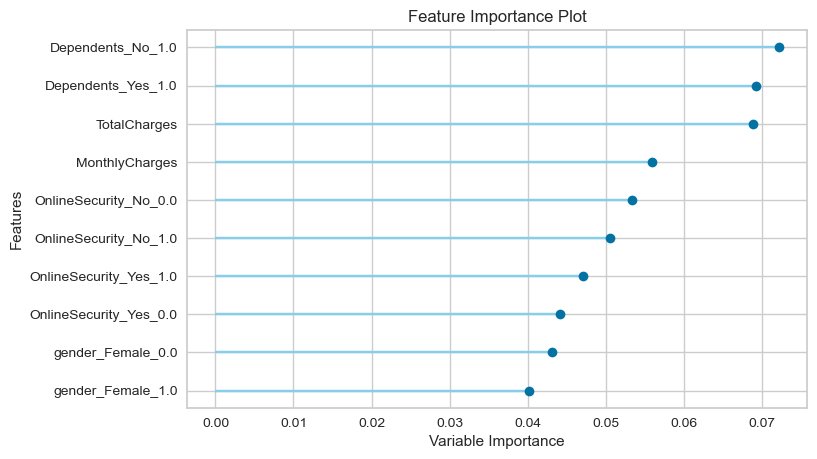

In [173]:
plot_model(tuned_lr, plot = 'feature')

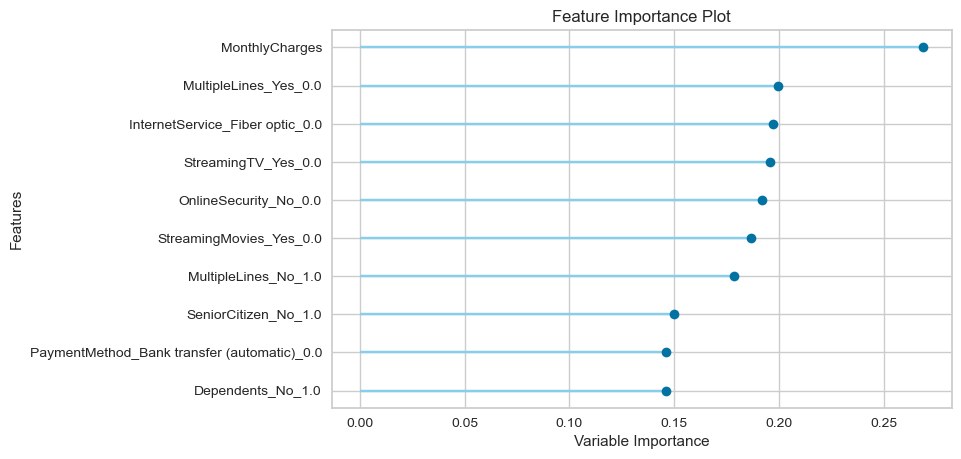

In [174]:
plot_model(tuned_lda, plot = 'feature')

In [175]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Select best model

In [176]:
best = automl(optimize = 'f1')
best

LogisticRegression(C=0.038, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [177]:
predictions_automl = predict_model(best, data=X_test)
predictions_automl.head()

,MonthlyCharges,TotalCharges,tenure,PhoneService_No,PhoneService_Yes,TechSupport_No,TechSupport_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,Dependents_No,Dependents_Yes,SeniorCitizen_No,SeniorCitizen_Yes,StreamingMovies_No,StreamingMovies_Yes,Partner_No,Partner_Yes,Label,Score
0,-0.489235,-0.983174,-1.281158,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,No,0.5111
1,0.309314,1.294997,1.545103,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,Yes,0.5510
2,1.317400,2.029444,1.299341,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,No,0.5507
3,-1.464323,-0.708643,0.070532,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Yes,0.5503
4,1.195308,-0.179071,-0.543873,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,No,0.6032


In [178]:
predictions_automl = predictions_automl['Label']
print(confusion_matrix(y_test, predictions_automl))
print(classification_report(y_test, predictions_automl))

[[495 825]
 [261 215]]
              precision    recall  f1-score   support

          No       0.65      0.38      0.48      1320
         Yes       0.21      0.45      0.28       476

    accuracy                           0.40      1796
   macro avg       0.43      0.41      0.38      1796
weighted avg       0.54      0.40      0.43      1796

